# **Predict change in b-cells in Tocilizumab treated samples**
In this notebook I use the models trained in the hyperparameter search in order to train BuDDI for learning the cell-type specific effect of Tocilizumab.
We use untreated single cell data from [1] and paired bulk untreated and treated (16weeks) from [2] to infer the cell-type specific treatment effect.
We specifically focus on analyzing the pathway-specific changes in each cell-type before and after treatment.

1. Zhang, F. et al. Deconstruction of rheumatoid arthritis synovium defines inflammatory subtypes. Nature 623, 616–624 (2023).
DOI:10.1038/s41586-023-06708-y

2. Rivellese, F. et al. Rituximab versus tocilizumab in rheumatoid arthritis: synovial biopsy-based biomarker analysis of the phase 4 R4RA randomized trial. Nat. Med. 28, 1256–1268 (2022).



# **Imports**

In [1]:
# import the VAE code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
from scipy.stats import rankdata, wilcoxon, ttest_ind, ttest_rel, spearmanr, pearsonr
from sklearn.metrics import average_precision_score, f1_score


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet
import anndata as ad
import gseapy as gp
from gseapy import GSEA

# programming stuff
import time
import os
import pickle
from pathlib import Path
from random import sample


# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model


# disable eager execution
# link to explanation why: https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/davidnat/

In [2]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_synovium_data/"
bulk_aug_data_path = f"{os.getcwd()}/../data/bulk_data/synovium/"
reference_data_path = f"{os.getcwd()}/../data/reference_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/buddiM2_synovium/"
clinical_file = f"{os.getcwd()}/../data/single_cell_data/synovium/metadata_clin_donor_singlecell.csv"

# results files for cibersort and bayesprism
bp_bulk_path = f"{os.getcwd()}/../results/single_cell_data/bp_synovium/bp_tocilizumab_prop.tsv"
bp_00_bulk_path = f"{os.getcwd()}/../results/single_cell_data/bp_synovium/bp_tocilizumab_prop_00.tsv"
bp_01_bulk_path = f"{os.getcwd()}/../results/single_cell_data/bp_synovium/bp_tocilizumab_prop_01.tsv"
bp_bulk_Z_path = f"{os.getcwd()}/../results/single_cell_data/bp_synovium/bp_tocilizumab_Z.tsv"
bp_bulk_Zmeta_path = f"{os.getcwd()}/../results/single_cell_data/bp_synovium/bp_tocilizumab_Z_meta.tsv"


gmt_path_hallmark = f"{os.getcwd()}/../data/metadata/h.all.v2023.2.Hs.symbols.gmt"
gmt_path_reactome = f"{os.getcwd()}/../data/metadata/c2.cp.reactome.v2023.2.Hs.symbols.gmt"


cibersort_path = f"{os.getcwd()}/../data/single_cell_data/cibersort_synovium/"


cibersort_genes_path = (f"{os.getcwd()}/../results/single_cell_data/cibersort_synovium/" +
                        "CIBERSORTx_Job42_test_cybersort_sig_inferred_phenoclasses" +
                        ".CIBERSORTx_Job42_test_cybersort_sig_inferred_refsample.bm.K999.txt")

num_genes = 7000


exp_id = "all-synovium"
res_id = "toc-synovium"
curr_treatment = "Tocilizumab"

RUN_CIBERSORT_GENES = True


# Set-up experimental variables

In [3]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 8

# number of patients/domains/samples expected
n_tot_samples = 23 # 16 bulk and 7 single cell samples -- Tocilizumab

# number of drugs (in this case sexes used for prediction)
# one-hot encoded
n_drugs = 2

# number of types of sequencing (one-hot encoded)
n_tech = 2


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [4]:
in_name = f"synovium_bulk_processed_{curr_treatment}"


# read in the real bulk data
processed_sc_file = f"{bulk_aug_data_path}/{in_name}.h5ad"
adata = sc.read_h5ad(processed_sc_file)

responder_ids = ['R4RAPAT00027', 'R4RAPAT00047','R4RAPAT00060',
                'R4RAPAT00110', 'R4RAPAT00129', 'R4RAPAT00140', ]

non_responderids = [ 'R4RAPAT00056', 'R4RAPAT00066', 'R4RAPAT00072', 
                    'R4RAPAT00099', 'R4RAPAT00107', 'R4RAPAT00114', 
                    'R4RAPAT00117', 'R4RAPAT00118', 'R4RAPAT00142', 'R4RAPAT00145']



# now get the sc ref training data

# read in order
sample_order = ['BRI-462', 'BRI-458', 'BRI-460', 'BRI-421',
                'BRI-515', 'BRI-415', 'BRI-436']


X_concat = None
Y_concat = None
meta_concat = None
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, "CTRL", "Train", exp_id)
    pseudobulks_df.columns = gene_df

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])


# format the bulk data
real_bulk_df = pd.DataFrame(adata.X.todense(), columns=adata.var_names, index=adata.obs.index)
real_bulk_meta_df = adata.obs

# select genes that are in both
intersect_genes = np.intersect1d(gene_df, real_bulk_df.columns)
X_concat = X_concat[intersect_genes]
real_bulk_df = real_bulk_df[intersect_genes]

# now we have a new gene_df
gene_df = pd.DataFrame(intersect_genes)
gene_df.columns = ["gene_ids"]
gene_df.set_index(gene_df["gene_ids"])
gene_df = gene_df.gene_ids

# get the bulk metadata formatted
real_bulk_meta_df['response'] = real_bulk_meta_df['cdai_response_status'].astype(str)
real_bulk_meta_df = real_bulk_meta_df[["sample_id", "stim", "response"]]
real_bulk_meta_df["isTraining"] = "Train"
real_bulk_meta_df["cell_prop_type"] = "realistic"
real_bulk_meta_df["samp_type"] = "bulk"
real_bulk_meta_df['sample_id'] = real_bulk_meta_df['sample_id'].astype(str)

meta_concat['response'] = 'Non.Responder'


# put the reference singlecell and real bulk it all together
X_full = pd.concat([X_concat, real_bulk_df])
Y_full = pd.concat([Y_concat, Y_concat.iloc[range(real_bulk_df.shape[0])]]) ## stop gap for now
meta_df = pd.concat([meta_concat, real_bulk_meta_df])

# add clinical info
clinical_df = pd.read_csv(clinical_file)
clinical_df = meta_df.merge(clinical_df, left_on="sample_id", right_on="mRNA_run", how='left')
meta_df = clinical_df

# index for checking correlations
sc_idx = np.where(meta_df.samp_type != "bulk")[0]
bulk_idx = np.where(meta_df.samp_type == "bulk")[0]



BRI-462
BRI-458
BRI-460
BRI-421
BRI-515
BRI-415
BRI-436


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_85974/3530234410.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bulk_meta_df["isTraining"] = "Train"
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_85974/3530234410.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bulk_meta_df["cell_prop_type"] = "realistic"
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_85974/3530234410.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [5]:
tab = meta_df.groupby(['samp_type', 'response']).size()
tab.unstack()

response   Non.Responder  Responder
samp_type                          
bulk                20.0       12.0
sc_ref           40600.0        NaN

### format sample indices and get variable genes

In [6]:
meta_df.isTraining.unique()

array(['Train'], dtype=object)

In [7]:

##################################################
#####. Design the experiment
##################################################


X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.stim)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)


idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim == "STIM")[0]
idx_random = np.where(meta_df.cell_prop_type == "random")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]


# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(gene_df, cibersort_genes)



# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))

# need to get the genes such that
# the union of the highly variable and the
# CIBERSORTx genes are 7000 total
num_genes_found = False
initial_count = 7000
while not num_genes_found:
    idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:]
    top_gene_df = gene_df.iloc[idx_top]
    CoV_only = np.union1d(top_gene_df, cibersort_genes)
    #CoV_only = top_gene_df
    if len(CoV_only) == 7000:
        num_genes_found = True
    else:
        initial_count = initial_count -1

idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:] # num_genes to get 7000
gene_df = gene_df.iloc[idx_top]


In [8]:
X_orig

array([[3.7000e+01, 3.0000e+00, 1.1000e+02, ..., 9.5000e+01, 1.0800e+02,
        4.5000e+01],
       [2.2000e+01, 2.0000e+00, 7.4000e+01, ..., 1.1700e+02, 1.6500e+02,
        3.9000e+01],
       [1.4000e+01, 2.0000e+00, 8.4000e+01, ..., 8.6000e+01, 1.2000e+02,
        4.9000e+01],
       ...,
       [3.4900e+02, 4.9000e+01, 2.1424e+04, ..., 8.4800e+02, 7.0270e+03,
        2.3960e+03],
       [5.4400e+02, 2.0000e+00, 2.7840e+03, ..., 6.8600e+02, 5.6300e+02,
        3.9800e+02],
       [3.0300e+02, 3.4000e+01, 1.4574e+04, ..., 7.1300e+02, 5.7460e+03,
        1.8290e+03]])

In [9]:
X_CoV.shape

(16153,)

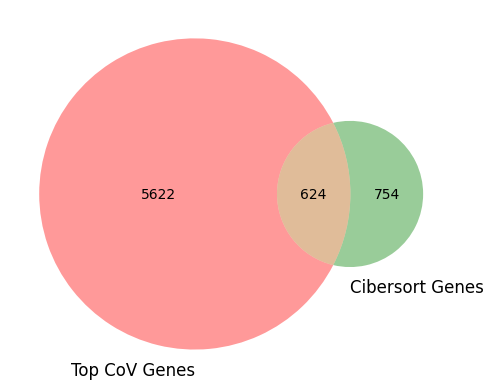

In [10]:
venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [11]:
union_genes = np.union1d(gene_df, cibersort_genes)
len(union_genes)

7000

In [12]:
np.any(np.isin(union_genes, ["PRDM1"]))

True

### normalize

In [13]:
X_full = X_full.loc[:,union_genes]

# rescale sc_ref and bulks
median_sc_ref = np.median(np.quantile(X_full.iloc[sc_idx], axis=1, q=0.9))
median_bulk = np.median(np.quantile(X_full.iloc[bulk_idx], axis=1, q=0.9))

ratio_medians = median_bulk/median_sc_ref

X_full.iloc[sc_idx] = X_full.iloc[sc_idx]*ratio_medians


In [14]:

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
bulk_unkp = bulk_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
bulk_kp = bulk_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()


### plot data

In [15]:
idx_tmp = np.random.choice(range(X_full.shape[0]), 5000, replace=True)
idx_tmp

array([12022,  1698, 30111, ..., 16343,  8656, 16468])

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 3.138s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.104220
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.203476
[t-SNE] KL divergence after 500 iterations: 1.199428
(5000, 2)
(5000, 2)


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_85974/2600809812.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


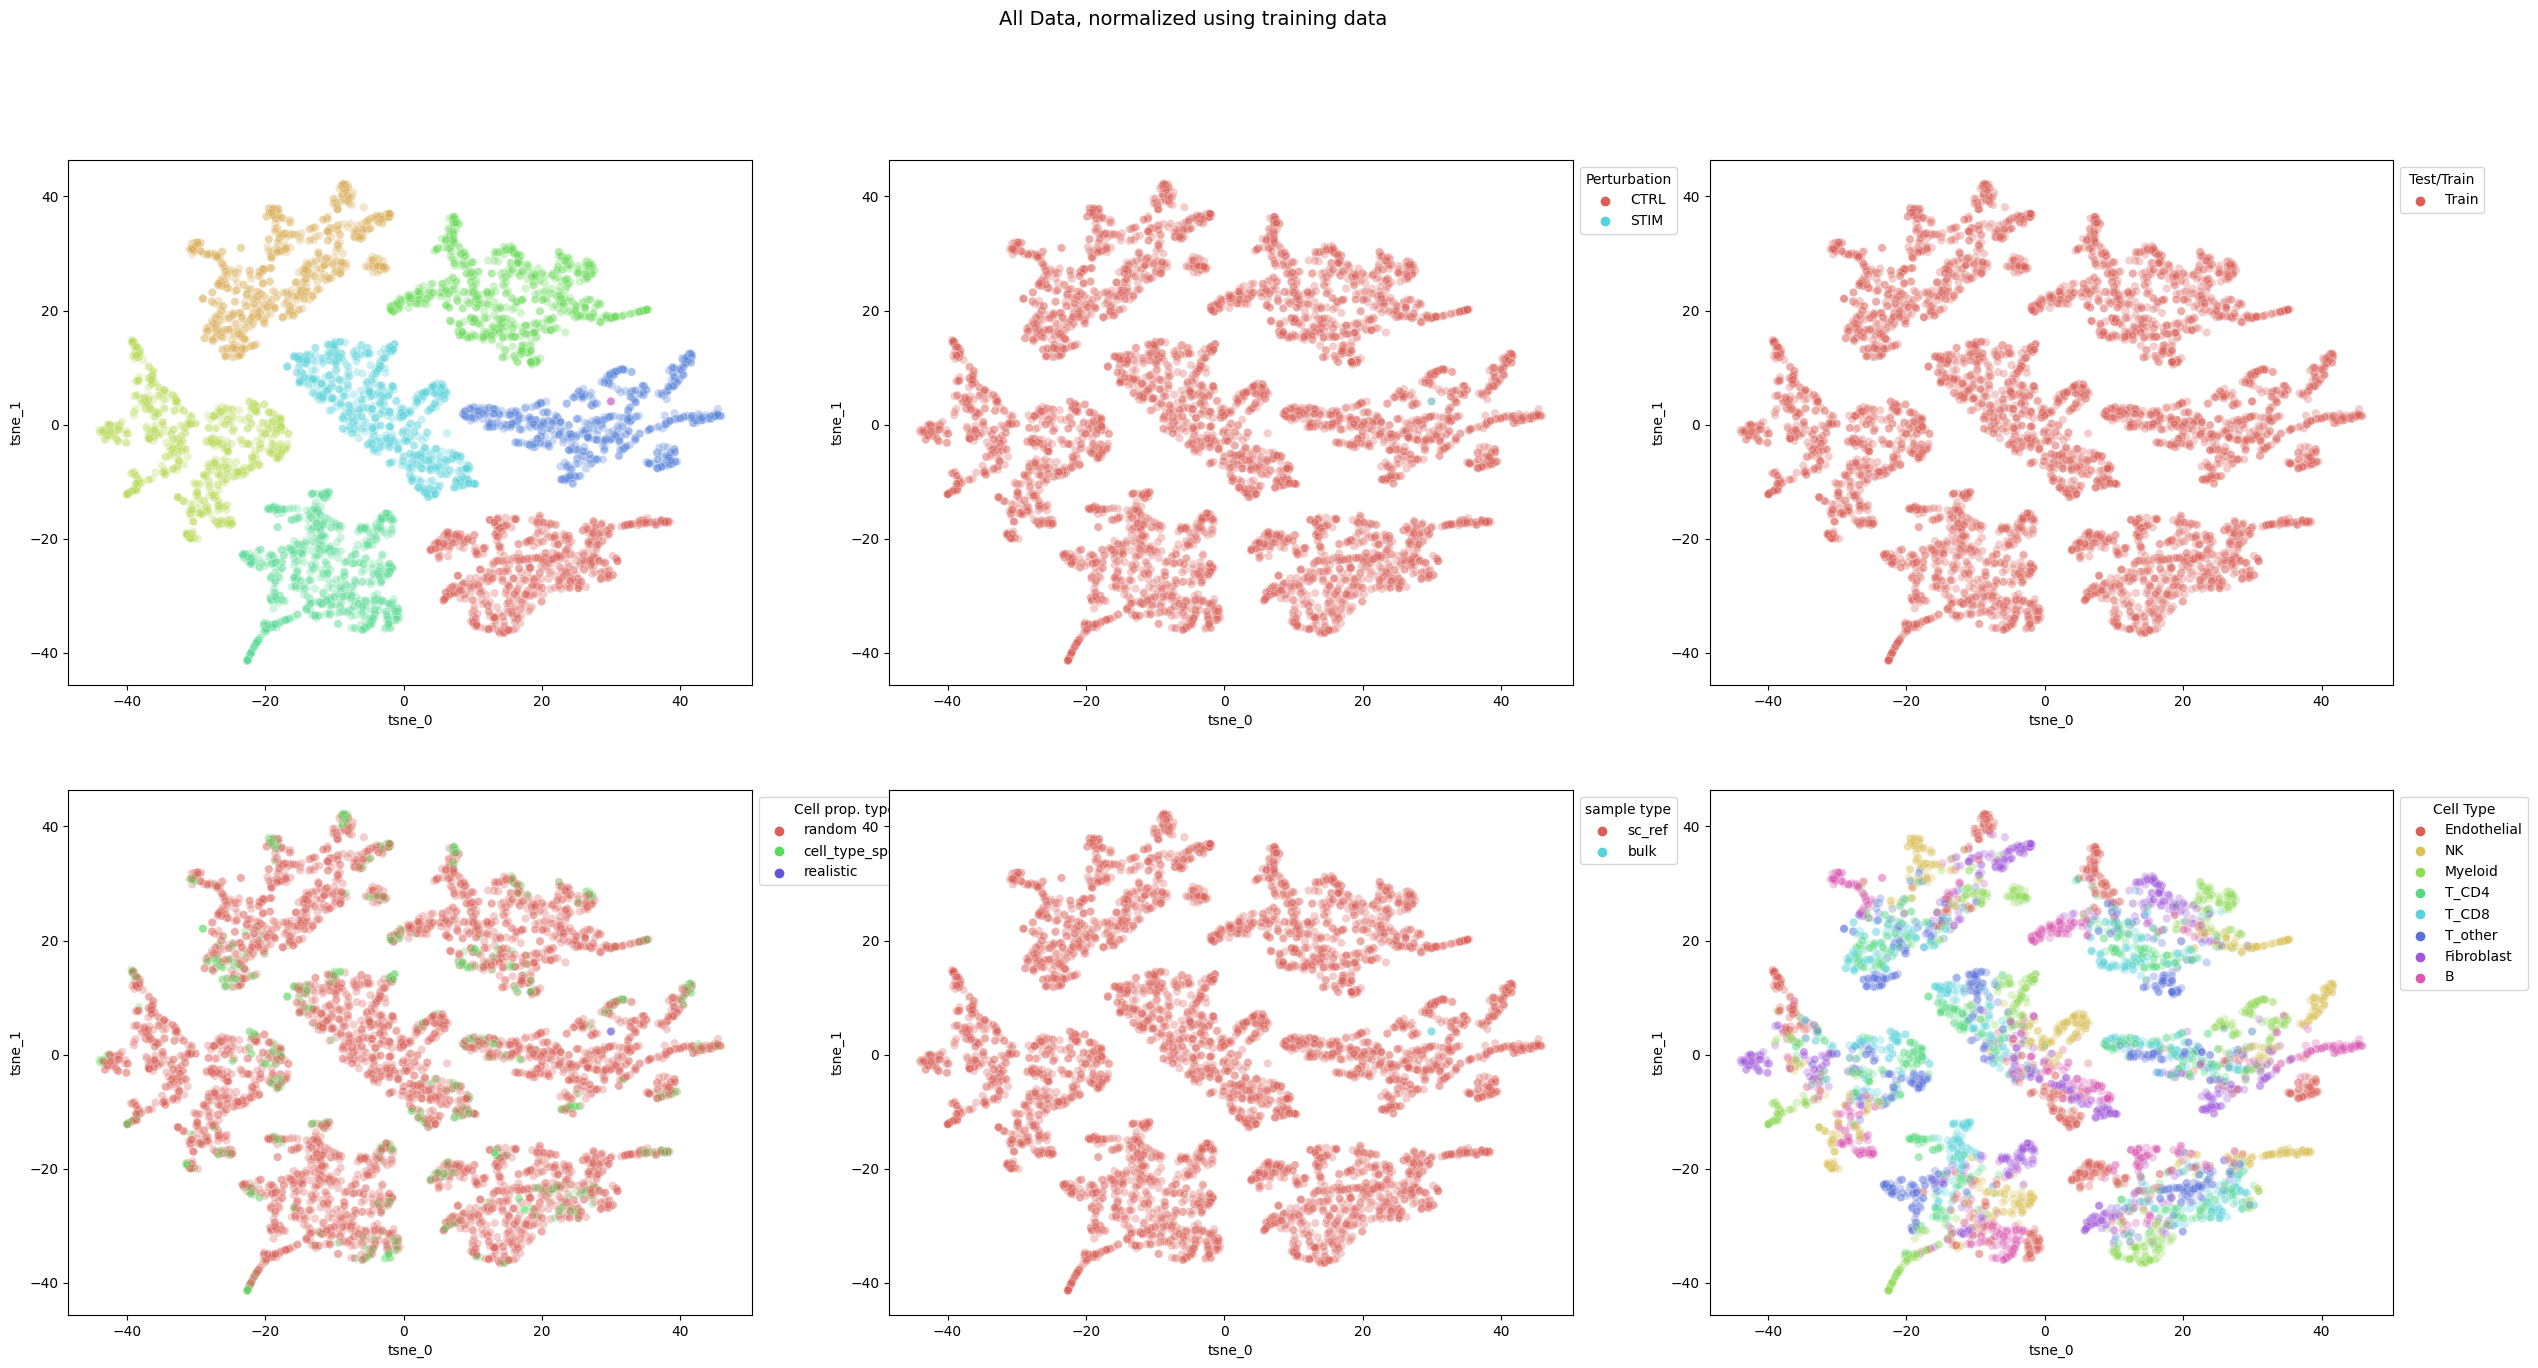

In [16]:
## plot samples

idx_tmp = np.random.choice(range(X_full.shape[0]), 5000, replace=True)

plot_df = vp.get_tsne_for_plotting(X_full[idx_tmp,])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

# this is a vector that represents the cell-type with 
# the highest proportion 
Y_temp = np.copy(Y_full.iloc[idx_tmp])
Y_temp = np.argmax(Y_temp, axis=1) 
Y_temp = Y_full.columns[Y_temp]


vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].sample_id.to_numpy(), axs[0,0], title=f"", legend_title="Sample ID")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].stim.to_numpy(), axs[0,1], title=f"", legend_title="Perturbation")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].isTraining.to_numpy(), axs[0,2], title=f"", legend_title="Test/Train")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].cell_prop_type.to_numpy(), axs[1,0], title=f"", legend_title="Cell prop. type")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].samp_type.to_numpy(), axs[1,1], title=f"", legend_title="sample type")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"", legend_title="Cell Type")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


(32, 2)
(32, 2)


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_85974/2821073111.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


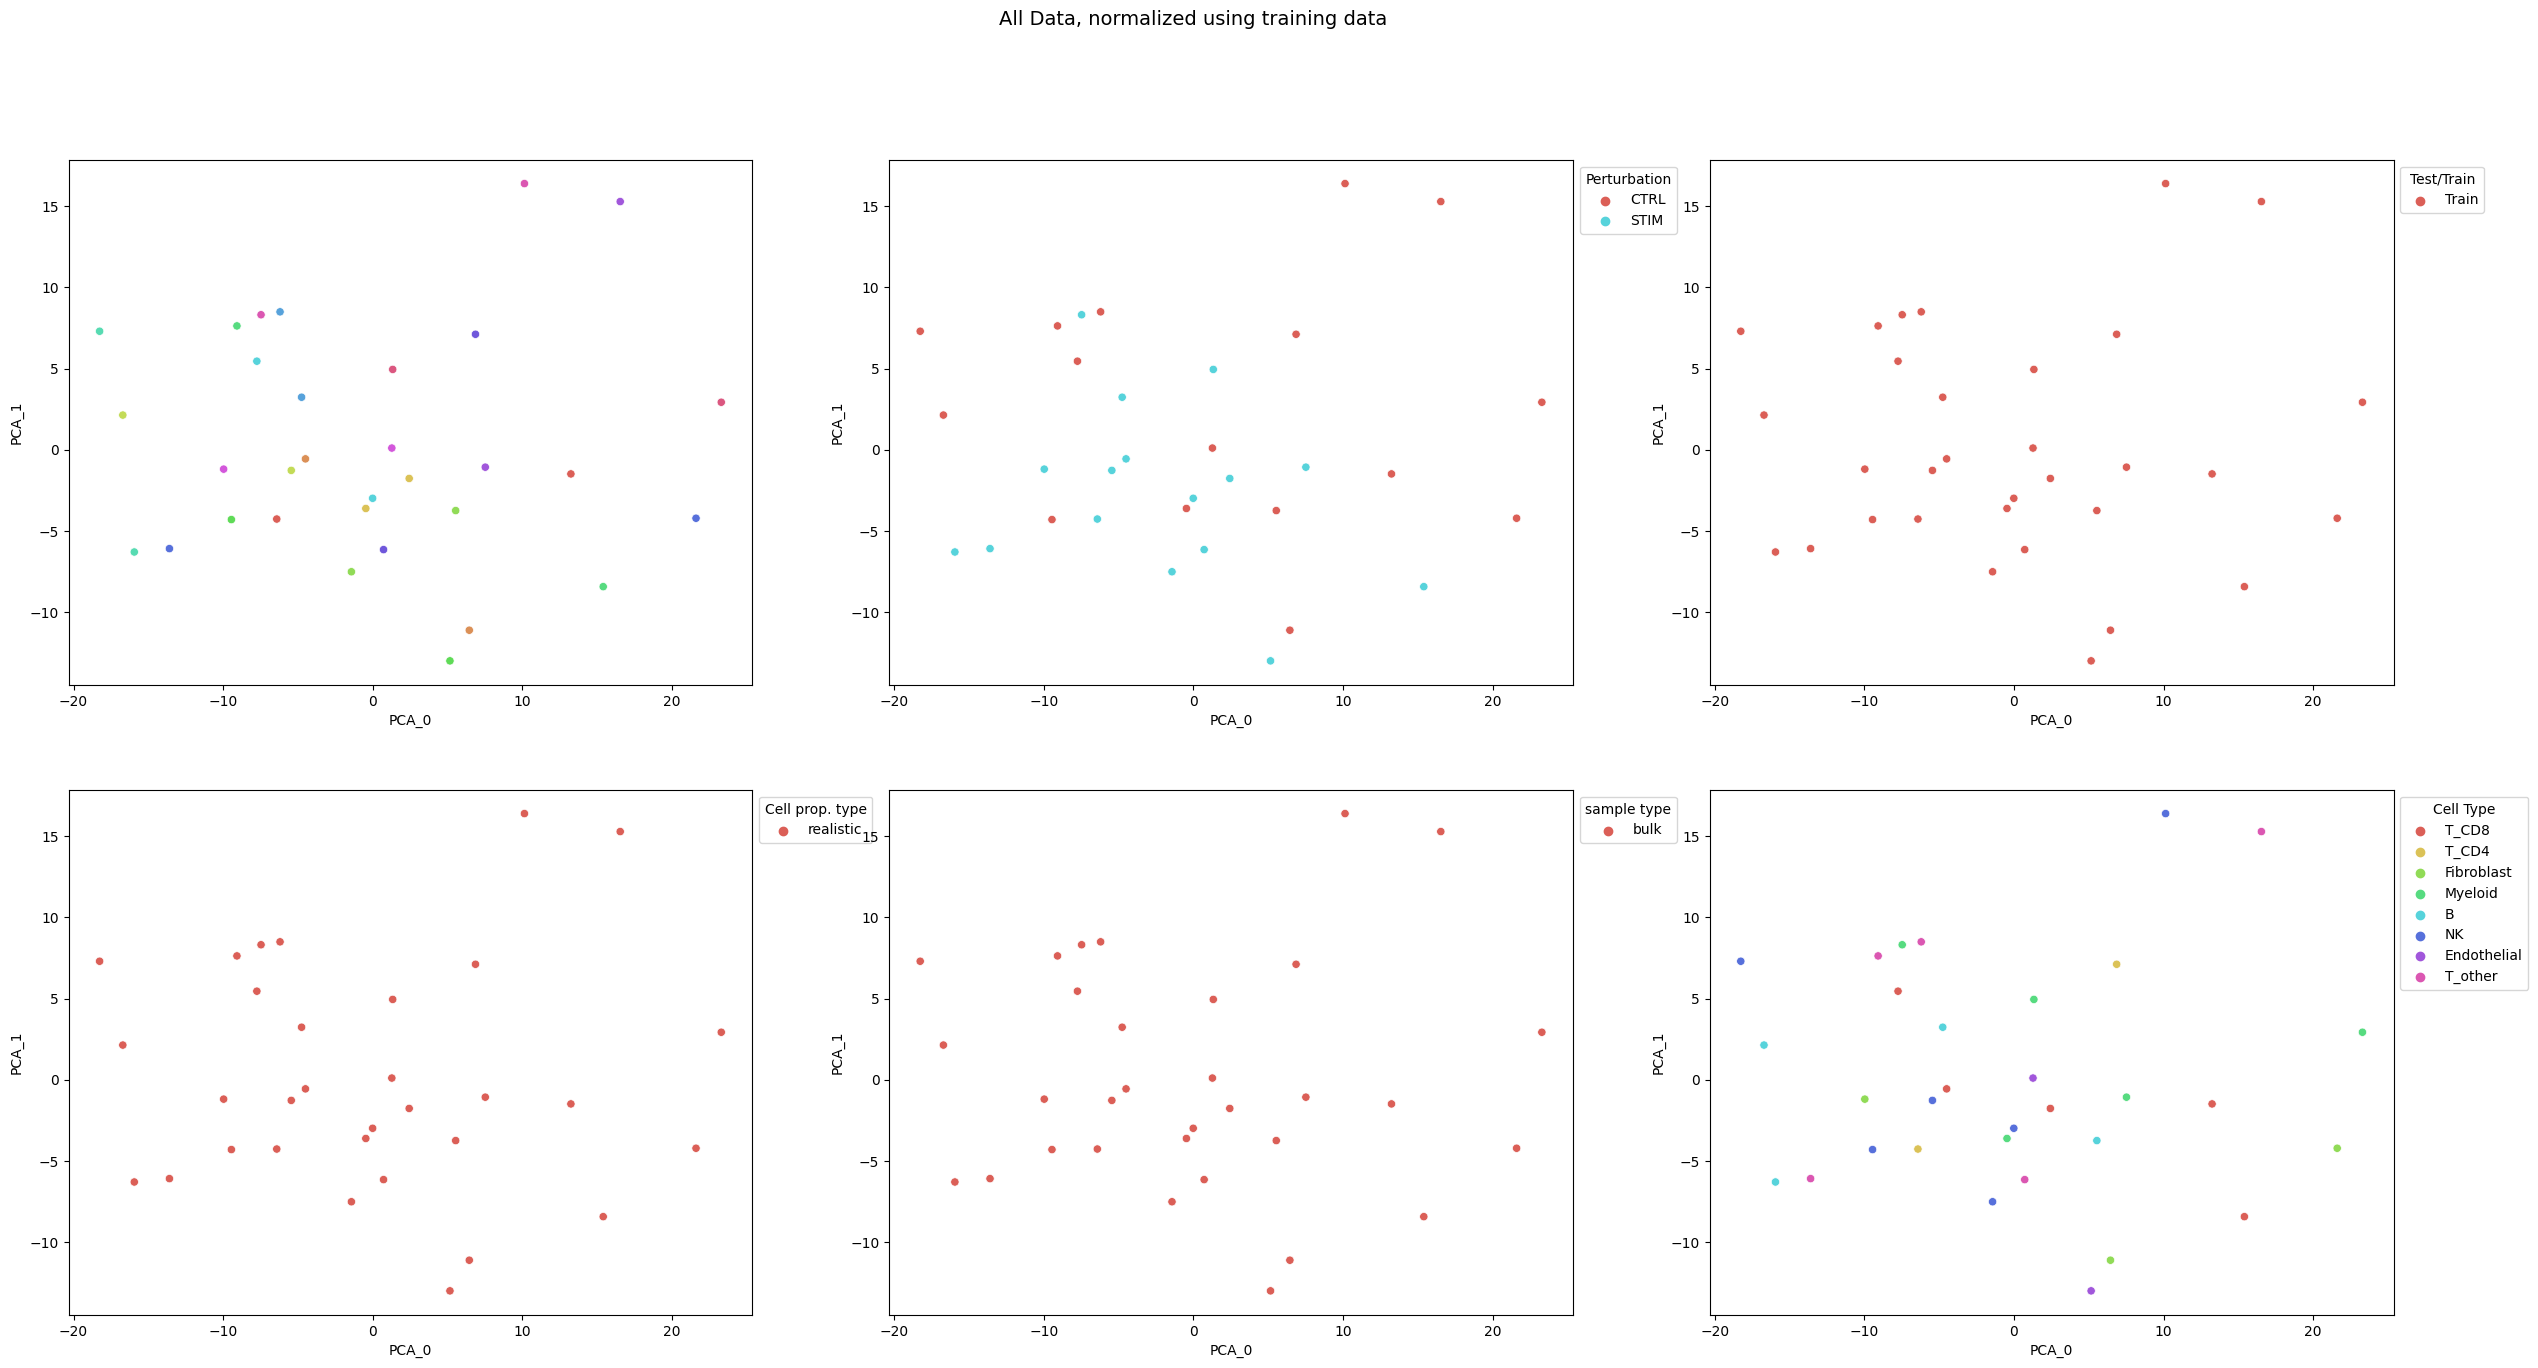

In [17]:
## plot samples
idx_interest = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]

plot_df = vp.get_pca_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 
Y_temp = Y_full.columns[Y_temp]

vp.plot_pca(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], title=f"", alpha=1, legend_title="Sample ID")
vp.plot_pca(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], title=f"", alpha=1, legend_title="Perturbation")
vp.plot_pca(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], title=f"", alpha=1, legend_title="Test/Train")
vp.plot_pca(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], title=f"", alpha=1, legend_title="Cell prop. type")
vp.plot_pca(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], title=f"", alpha=1, legend_title="sample type")
vp.plot_pca(plot_df, Y_temp, axs[1,2], title=f"", alpha=1, legend_title="Cell Type")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 32 samples in 0.000s...
[t-SNE] Computed neighbors for 32 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 32 / 32
[t-SNE] Mean sigma: 13.369884
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.740921
[t-SNE] KL divergence after 500 iterations: 0.066505
(32, 2)
(32, 2)


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_85974/2955274557.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


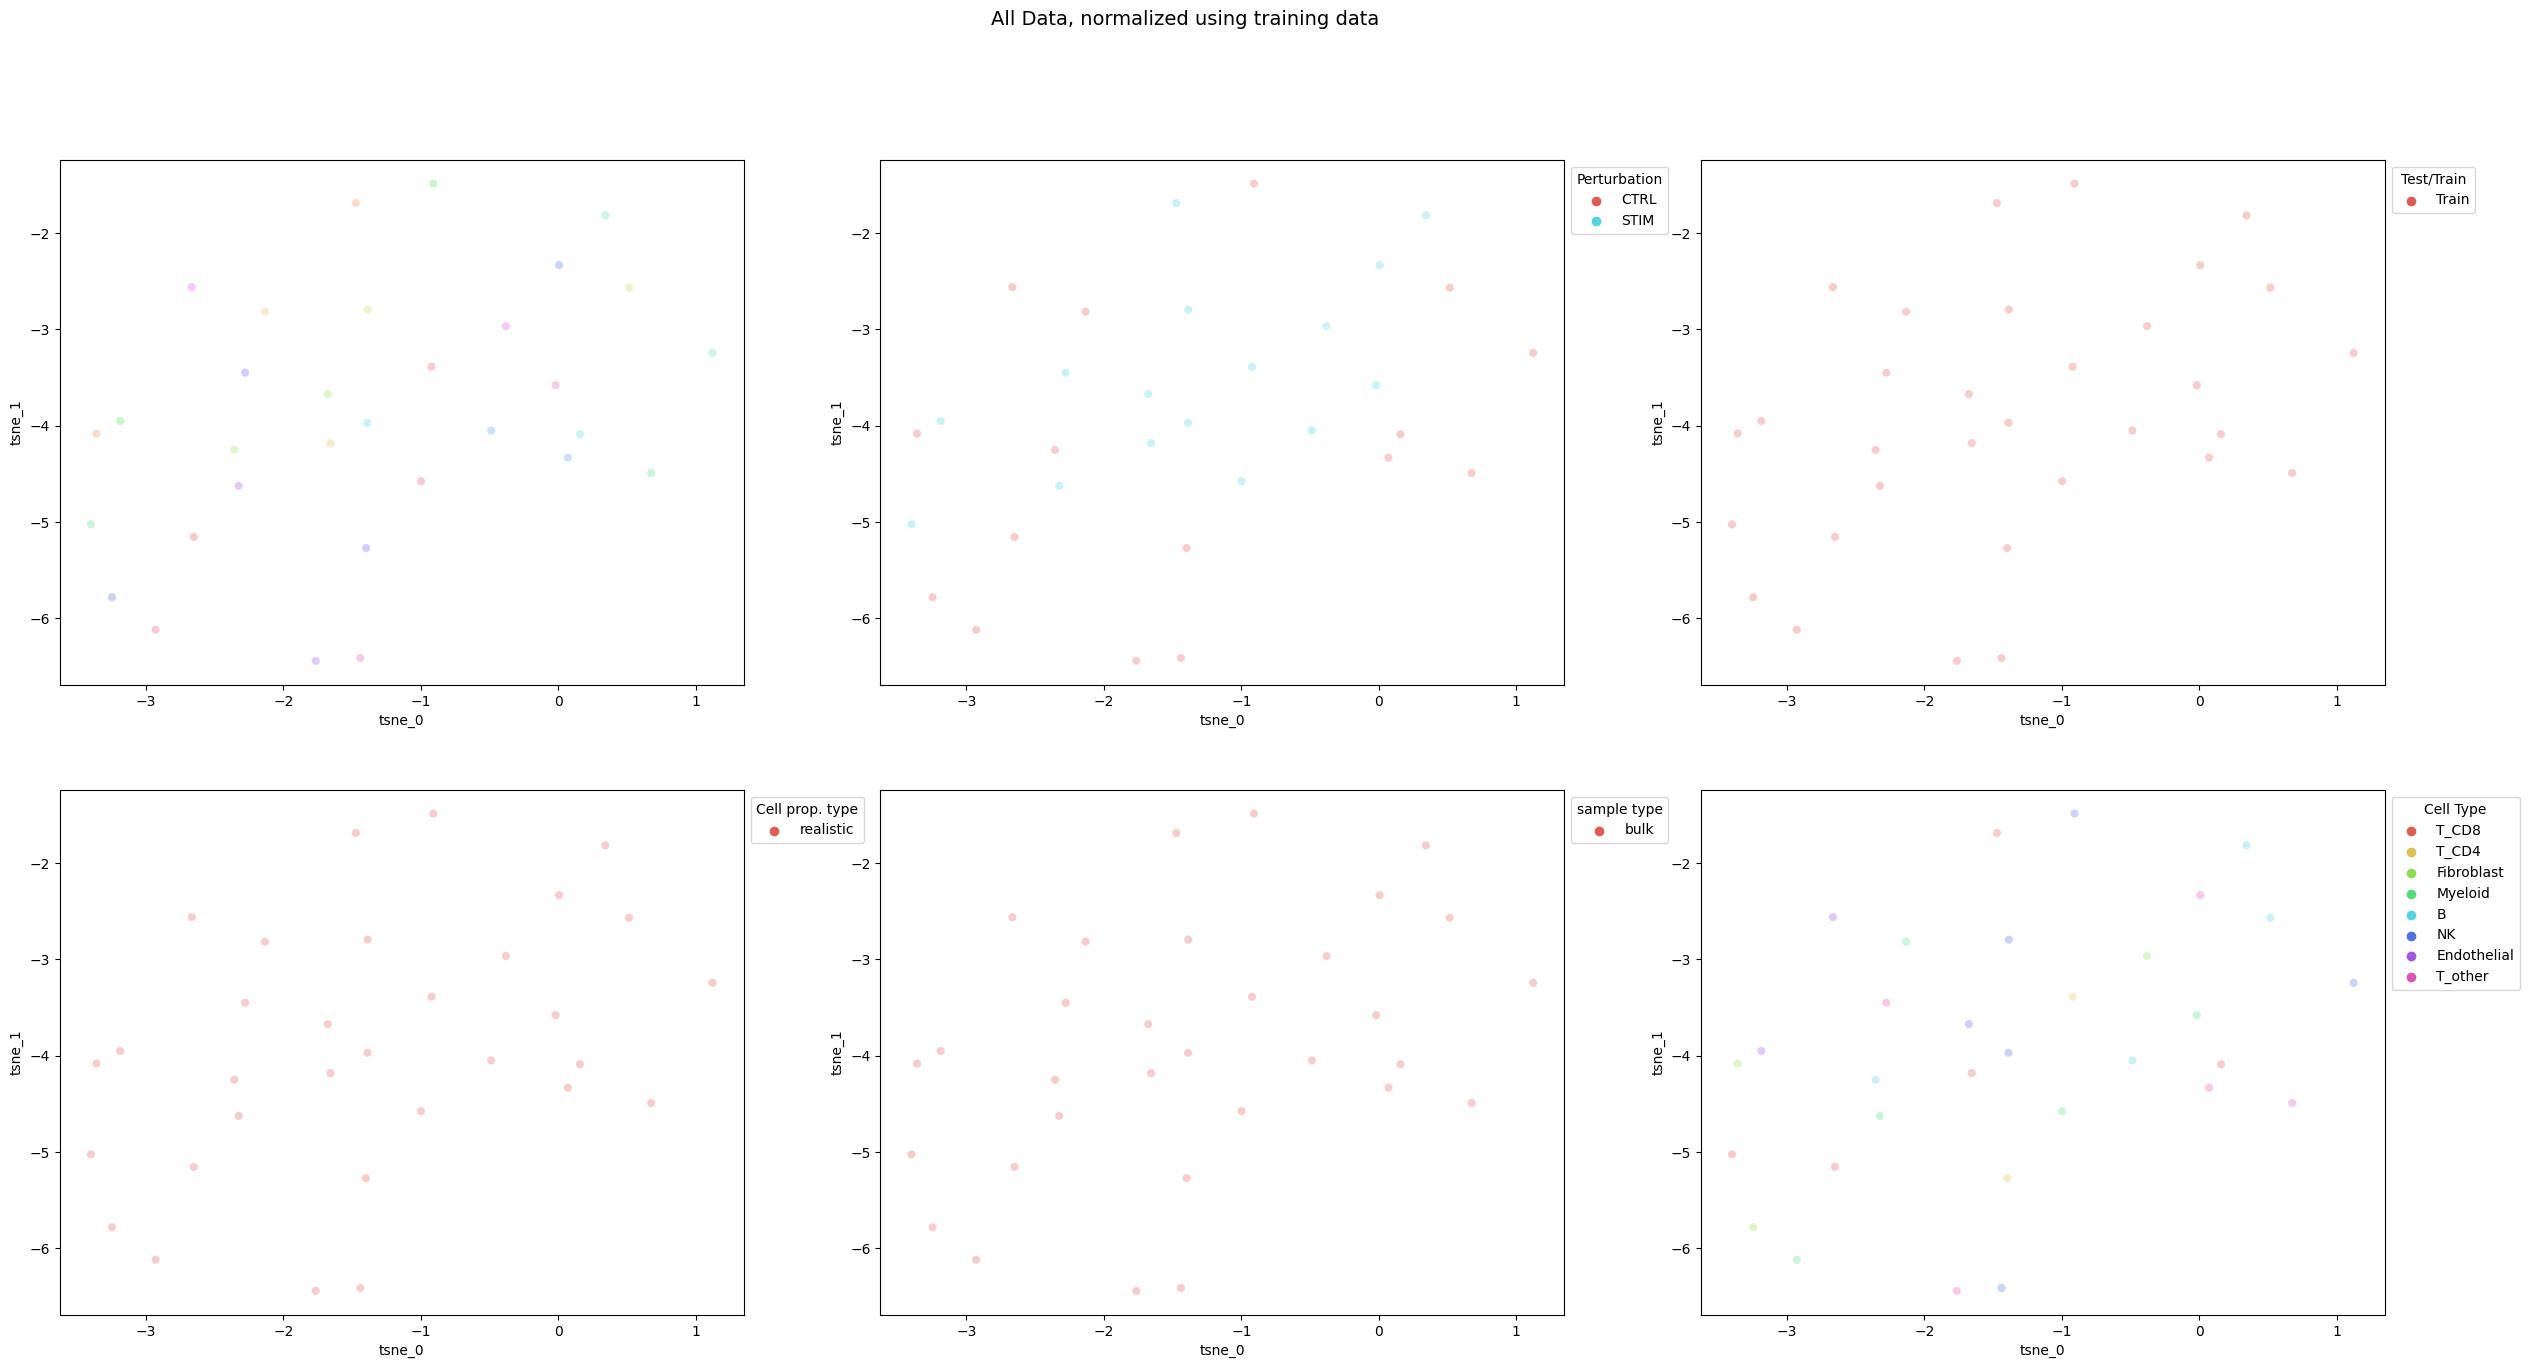

In [18]:
## plot samples
idx_interest = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]

plot_df = vp.get_tsne_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 
Y_temp = Y_full.columns[Y_temp]

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], alpha=1, title=f"", legend_title="Sample ID")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], alpha=1, title=f"", legend_title="Perturbation")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], alpha=1, title=f"", legend_title="Test/Train")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], alpha=1, title=f"", legend_title="Cell prop. type")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], alpha=1, title=f"", legend_title="sample type")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"", alpha=1, legend_title="Cell Type")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


# **Read in Trained Models**

In [19]:
""" 
res1_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/300_model1_{res_id}_encoder_unlab")
res1_enc_lab = tf.keras.models.load_model(f"{res_data_path}/300_model1_{res_id}_encoder_lab")
res1_dec = tf.keras.models.load_model(f"{res_data_path}/300_model1_{res_id}_decoder")
res1_classifier = tf.keras.models.load_model(f"{res_data_path}/300_model1_{res_id}_classifier")

"""
res1_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/model1_{res_id}_encoder_unlab")
res1_enc_lab = tf.keras.models.load_model(f"{res_data_path}/model1_{res_id}_encoder_lab")
res1_dec = tf.keras.models.load_model(f"{res_data_path}/model1_{res_id}_decoder")
res1_classifier = tf.keras.models.load_model(f"{res_data_path}/model1_{res_id}_classifier")



res2_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/model2_{res_id}_encoder_unlab")
res2_enc_lab = tf.keras.models.load_model(f"{res_data_path}/model2_{res_id}_encoder_lab")
res2_dec = tf.keras.models.load_model(f"{res_data_path}/model2_{res_id}_decoder")
res2_classifier = tf.keras.models.load_model(f"{res_data_path}/model2_{res_id}_classifier")


res3_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/model3_{res_id}_encoder_unlab")
res3_enc_lab = tf.keras.models.load_model(f"{res_data_path}/model3_{res_id}_encoder_lab")
res3_dec = tf.keras.models.load_model(f"{res_data_path}/model3_{res_id}_decoder")
res3_classifier = tf.keras.models.load_model(f"{res_data_path}/model3_{res_id}_classifier")



2024-02-12 13:46:47.653040: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-02-12 13:46:47.887102: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_5' id:266 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_5}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_10, Identity_5)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-02-12 13:46:48.634490: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_42' id:675 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_42}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_19, Identity_42)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-02-12 13:46:48.901888: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_50' id:837 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_50}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_25, Identity_50)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-02-12 13:46:49.112952: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_52' id:918 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_52}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_26, Identity_52)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-02-12 13:46:49.714468: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_62' id:1193 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_62}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_39, Identity_62)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-02-12 13:46:50.491840: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_97' id:1598 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_97}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_46, Identity_97)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-02-12 13:46:50.876801: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_108' id:1766 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_108}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_54, Identity_108)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-02-12 13:46:51.187734: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_114' id:1855 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_114}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_57, Identity_114)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-02-12 13:46:51.911807: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_128' id:2138 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_128}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_62, Identity_128)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-02-12 13:46:52.933314: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_158' id:2533 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_158}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_77, Identity_158)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-02-12 13:46:53.392630: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_167' id:2697 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_167}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_83, Identity_167)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-02-12 13:46:53.843244: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_170' id:2780 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_170}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_85, Identity_170)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


## Do latent space projectsions

### drug perturbation

In [20]:

res1_meta_df, res1_decoded_0_0, res1_decoded_0_1, res1_top_genes = buddi.calc_buddi_perturbation(meta_df, X_full, Y_full, scaler, 
                                                                            res1_enc_unlab, res1_dec, batch_size=500, 
                                                                            genes_ordered=union_genes, 
                                                                            top_lim=100, use_buddi4=True)



res2_meta_df, res2_decoded_0_0, res2_decoded_0_1, res2_top_genes = buddi.calc_buddi_perturbation(meta_df, X_full, Y_full, scaler, 
                                                                            res2_enc_unlab, res2_dec, batch_size=500, 
                                                                            genes_ordered=union_genes, 
                                                                            top_lim=100, use_buddi4=True)


res3_meta_df, res3_decoded_0_0, res3_decoded_0_1, res3_top_genes = buddi.calc_buddi_perturbation(meta_df, X_full, Y_full, scaler, 
                                                                            res3_enc_unlab, res3_dec, batch_size=500, 
                                                                            genes_ordered=union_genes, 
                                                                            top_lim=100, use_buddi4=True)



/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-02-12 13:46:56.163357: W tensorflow/c/c_api.cc:304] Operation '{name:'tf_op_layer_z_samp_slack_12/add/z_samp_slack_12/add' id:375 op device:{requested: '', assigned: ''} def:{{{node tf_op_layer_z_samp_slack_12/add/z_samp_slack_12/add}} = AddV2[T=DT_FLOAT, _cloned=true, _has_manual_control_dependencies=true](mu_slack/BiasAdd, tf_op_layer_z_samp_slack_12/mul/z_samp_slack_12/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/davidnat/Documents/projects/greenelab/buddi/buddi/buddi.py:893: SettingW

In [21]:
# make anndata for BuDDI
def make_anndata_buddi(res1_decoded_0_0, res1_decoded_0_1, res1_meta_df, union_genes):

    adata_counts = np.append(res1_decoded_0_0, res1_decoded_0_1, axis=0)
    adata_df = pd.DataFrame(adata_counts)
    adata_df.columns = union_genes

    ad_union_genes = pd.DataFrame(union_genes)
    ad_union_genes.index = union_genes

    res1_meta_df_stim = res1_meta_df.copy()
    res1_meta_df_stim.stim = "STIM"
    res1_meta_df_obs = res1_meta_df.append(res1_meta_df_stim)

    adata = ad.AnnData(adata_df, obs=res1_meta_df_obs, var=ad_union_genes)

    return (adata, adata_df)


# make anndata for BayesPrism
def make_anndata_bayesprism(bp_bulk_Z_path, bp_bulk_Zmeta_path):
    
    ## get with bayesprism
    bp_bulk = pd.read_csv(bp_bulk_Z_path, delimiter="\t")
    bp_bulk_meta = pd.read_csv(bp_bulk_Zmeta_path, delimiter="\t")



    def get_stim_id(in_str):
        out_str = "STIM"
        if in_str == "week0":
            out_str = "CTRL"
            
        return(out_str)

    bp_bulk_meta['stim'] = [get_stim_id(str(x)) for x in bp_bulk_meta["time"].tolist()]



    bp_adata_df = pd.DataFrame(bp_bulk)
    bp_union_genes = bp_adata_df.columns
    bp_adata_df = bp_adata_df[bp_union_genes]

    ad_bp_union_genes = pd.DataFrame(bp_union_genes)
    ad_bp_union_genes.index = bp_union_genes


    # format meta data
    bp_bulk_meta["Y_max"] = bp_bulk_meta.cell_type


    # make anndata
    bp_adata = ad.AnnData(bp_adata_df, obs=bp_bulk_meta, var=ad_bp_union_genes)

    return (bp_adata, bp_adata_df)



## Format BuDDI and BayesPrism

In [22]:
adata_res1, adata_res1_df = make_anndata_buddi(res1_decoded_0_0, res1_decoded_0_1, res1_meta_df, union_genes)
adata_res2, adata_res2_df = make_anndata_buddi(res2_decoded_0_0, res2_decoded_0_1, res2_meta_df, union_genes)
adata_res3, adata_res3_df = make_anndata_buddi(res3_decoded_0_0, res3_decoded_0_1, res3_meta_df, union_genes)
bp_adata, bp_adata_df = make_anndata_bayesprism(bp_bulk_Z_path, bp_bulk_Zmeta_path)


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_85974/3037078427.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res1_meta_df_obs = res1_meta_df.append(res1_meta_df_stim)
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_85974/3037078427.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

## Run GSEA

In [23]:

def run_gsea(cell_type_list, gmt_path, adata, adata_df):


    cell_idx = np.where(np.isin(adata.obs.Y_max, cell_type_list))[0]


    hall_mark = gp.read_gmt(path=gmt_path)
    class_vector = adata[cell_idx, :].obs.stim.to_list() # STIM vs CTRL
    adata_gsea = adata_df.iloc[cell_idx].T
    adata_gsea["Gene"] = adata_gsea.index

    gs = GSEA(data=adata_gsea,
            gene_sets=hall_mark,
            classes = class_vector, # cls=class_vector
            # set permutation_type to phenotype if samples >=15
            permutation_type='phenotype',
            permutation_num=1000, # reduce number to speed up test
            outdir=None,
            method='ratio_of_classes',
            threads=4, seed= 8)
    gs.pheno_pos = "CTRL"
    gs.pheno_neg = "STIM"
    gs.run()

    return gs

def plot_gsea(gmt_path, cell_type_list, in_adata, inadata_df, title):

        gs_res_imm = run_gsea(cell_type_list, gmt_path, in_adata, inadata_df)

        out_fig = gp.dotplot(gs_res_imm.res2d,
                                column="FDR q-val",
                                title=title,
                                cmap=plt.cm.viridis,
                                size=5,
                                figsize=(4,5), cutoff=1)
        return (out_fig, gs_res_imm)



<AxesSubplot: title={'center': 'all_reactome_BuDDI'}, xlabel='NES'>

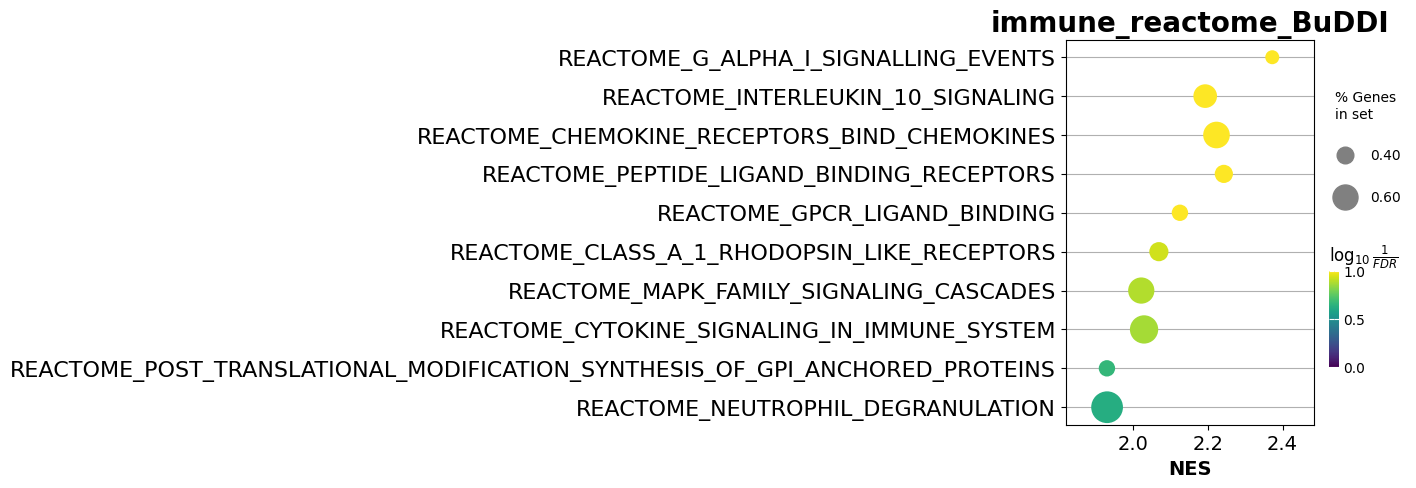

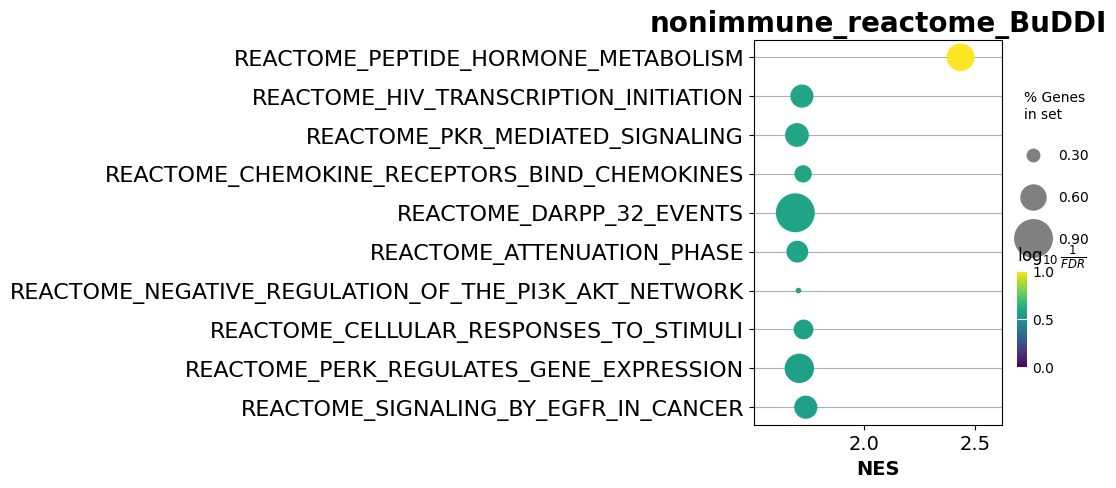

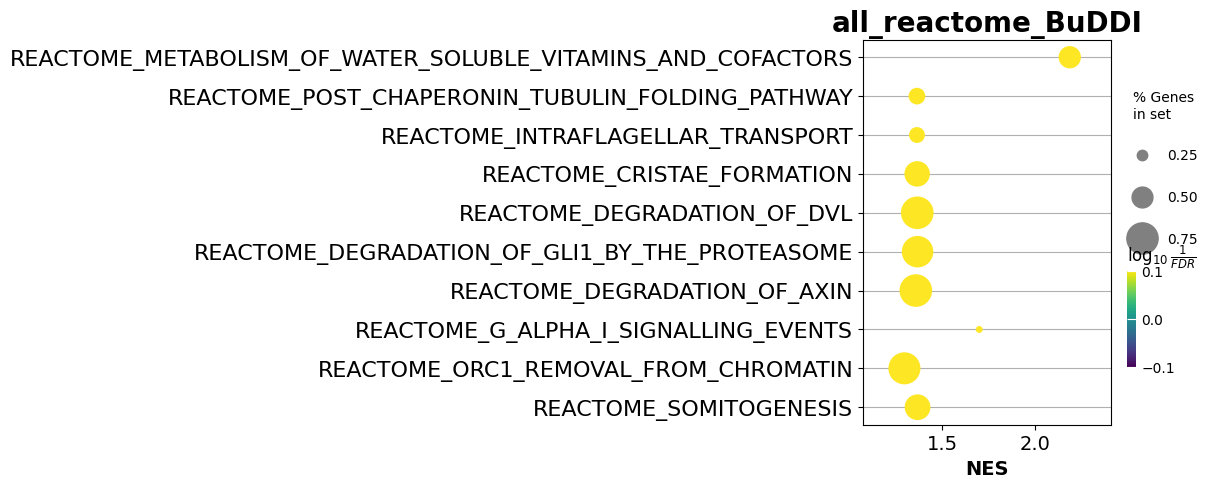

In [24]:
# BuDDI Reactome

gmt_path = gmt_path_reactome

cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other"]

title = "immune_reactome_BuDDI"
out_fig, immune_reactome_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res1, adata_res1_df, title)
out_fig

cell_type_list = ["Endothelial", "Fibroblast"]
title = "nonimmune_reactome_BuDDI"
out_fig, nonimmune_reactome_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res1, adata_res1_df, title)
out_fig


cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other", "Endothelial", "Fibroblast"]
title = "all_reactome_BuDDI"
out_fig, all_reactome_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res1, adata_res1_df, title)
out_fig

<AxesSubplot: title={'center': 'all_reactome_BuDDI'}, xlabel='NES'>

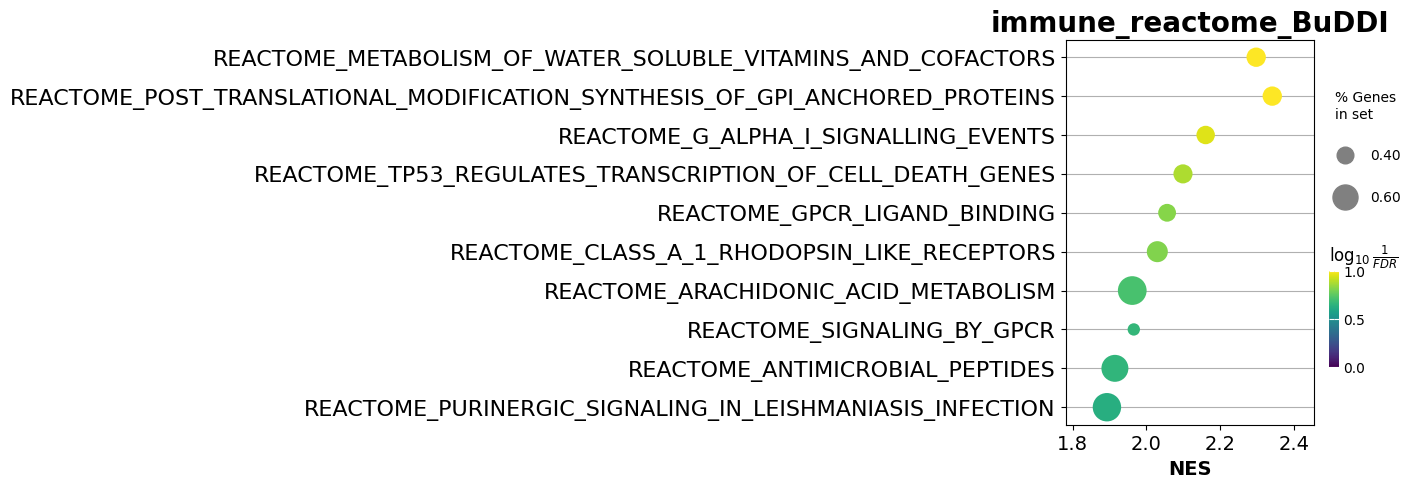

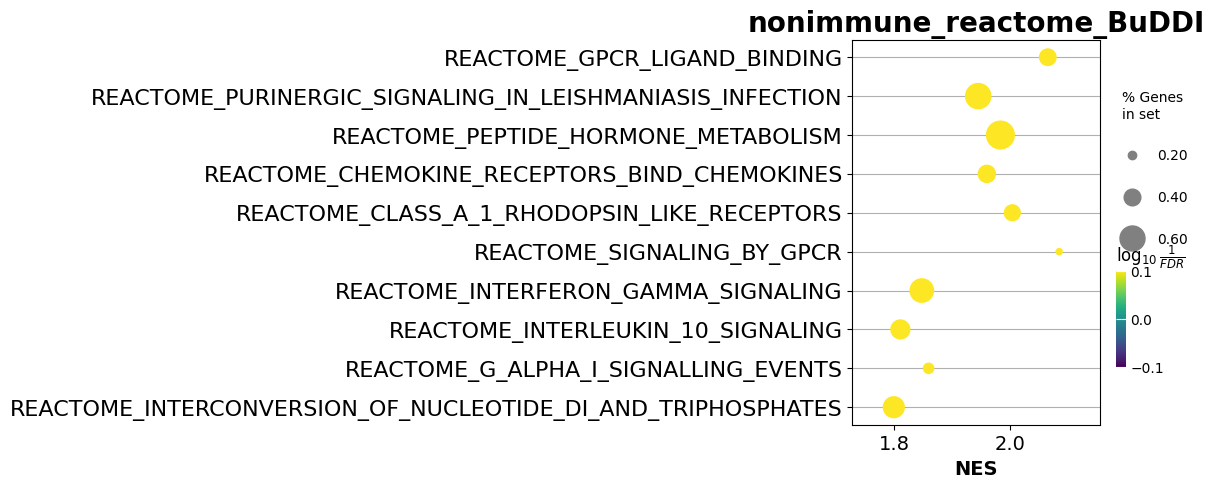

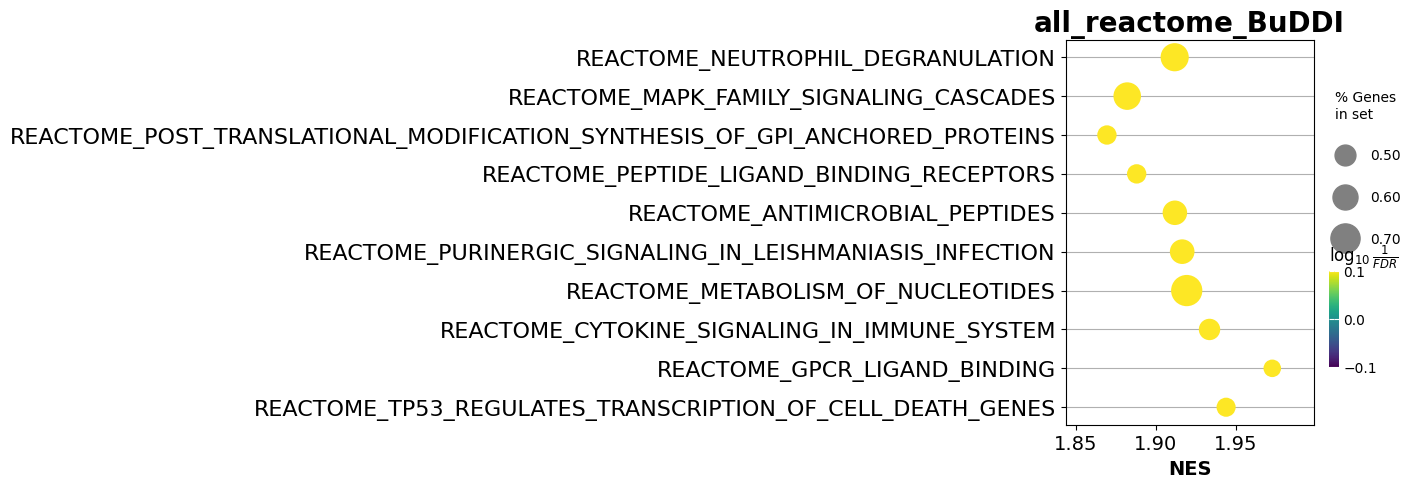

In [25]:
# BuDDI Reactome

gmt_path = gmt_path_reactome

cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other"]

title = "immune_reactome_BuDDI"
out_fig, immune_reactome_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res2, adata_res2_df, title)
out_fig

cell_type_list = ["Endothelial", "Fibroblast"]
title = "nonimmune_reactome_BuDDI"
out_fig, nonimmune_reactome_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res2, adata_res2_df, title)
out_fig


cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other", "Endothelial", "Fibroblast"]
title = "all_reactome_BuDDI"
out_fig, all_reactome_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res2, adata_res2_df, title)
out_fig

<AxesSubplot: title={'center': 'all_reactome_BuDDI'}, xlabel='NES'>

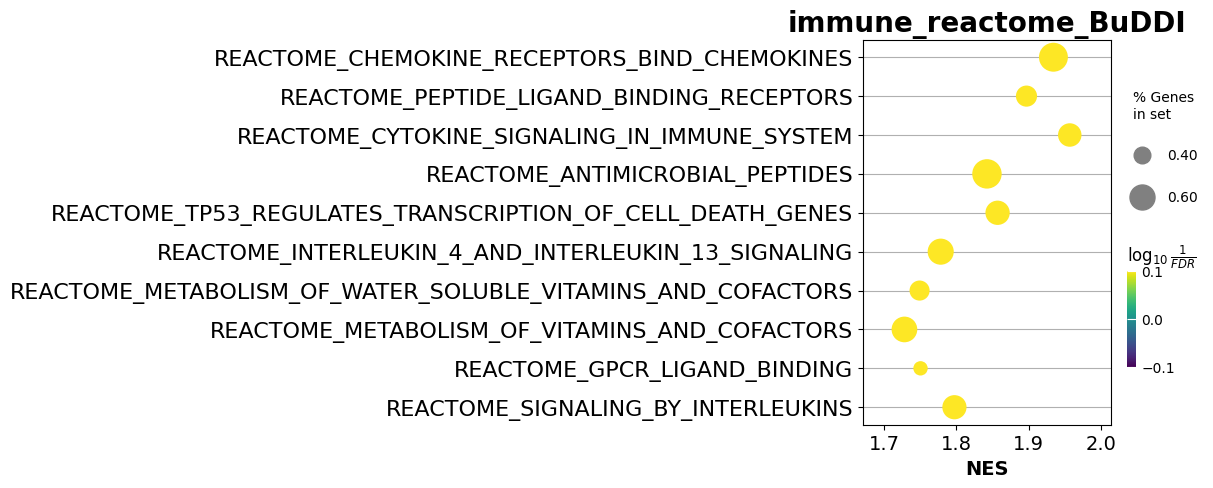

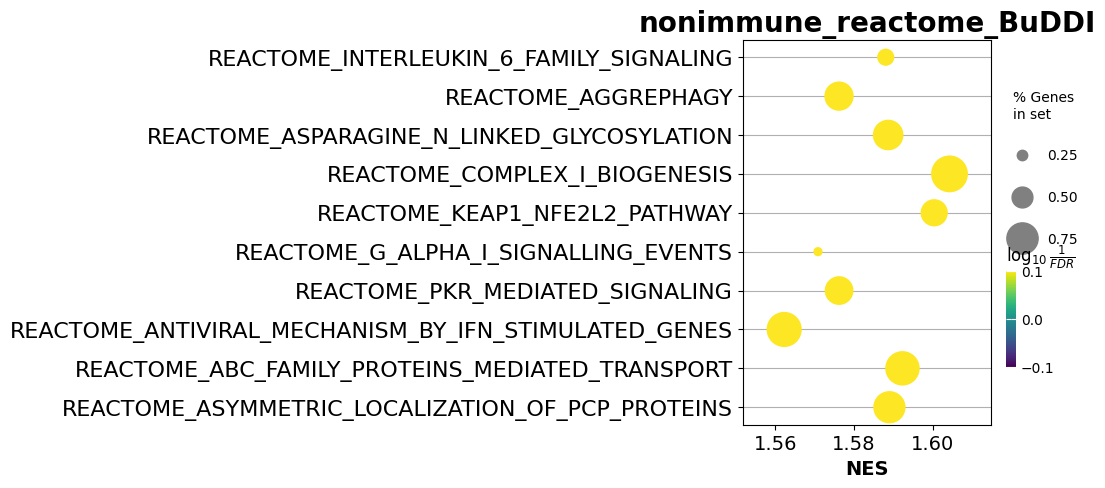

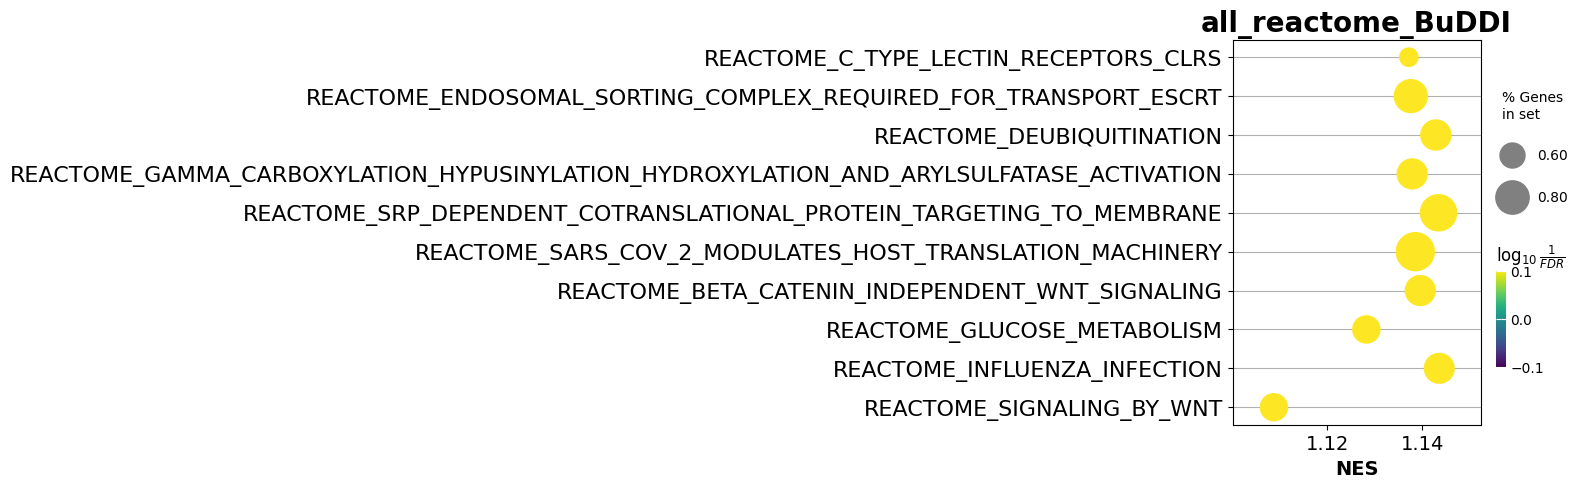

In [26]:
# BuDDI Reactome

gmt_path = gmt_path_reactome

cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other"]

title = "immune_reactome_BuDDI"
out_fig, immune_reactome_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res3, adata_res3_df, title)
out_fig

cell_type_list = ["Endothelial", "Fibroblast"]
title = "nonimmune_reactome_BuDDI"
out_fig, nonimmune_reactome_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res3, adata_res3_df, title)
out_fig


cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other", "Endothelial", "Fibroblast"]
title = "all_reactome_BuDDI"
out_fig, all_reactome_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res3, adata_res3_df, title)
out_fig

<AxesSubplot: title={'center': 'all_reactome_BP'}, xlabel='NES'>

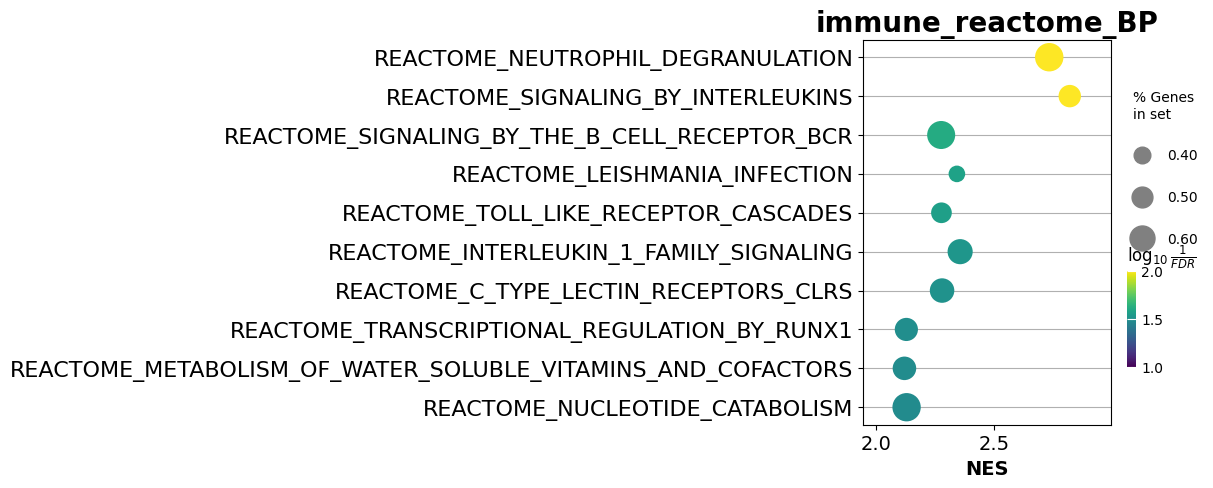

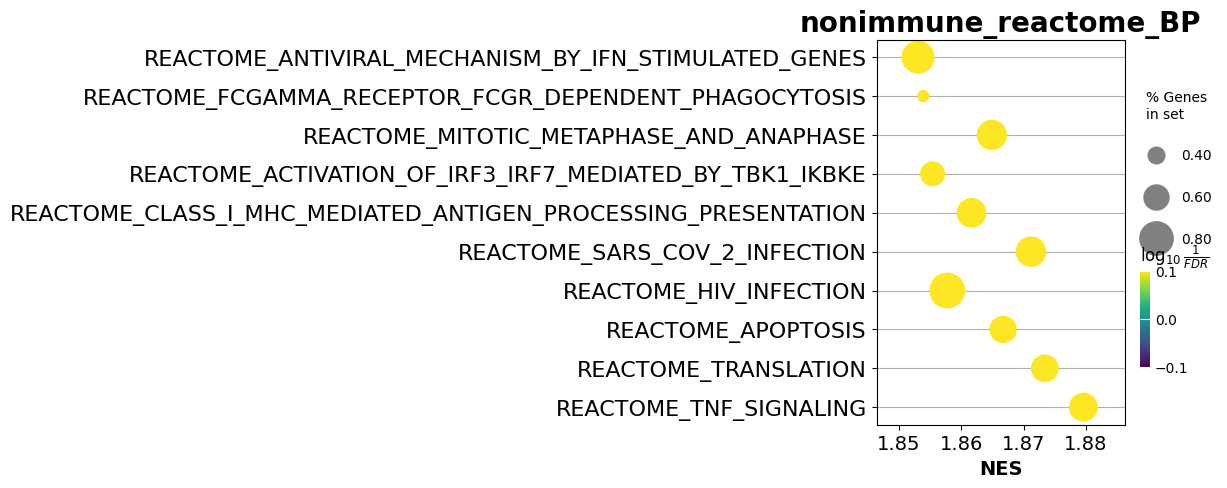

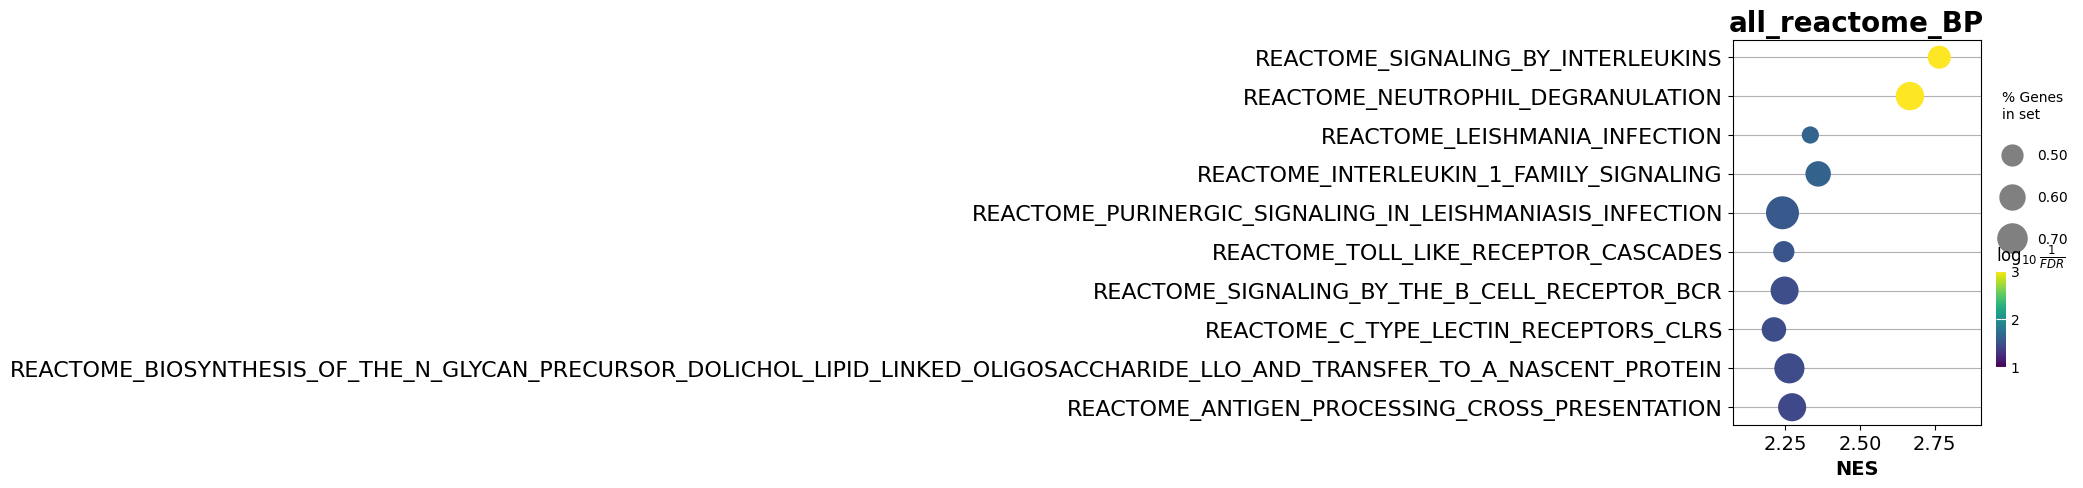

In [35]:
# BP Reactome

gmt_path = gmt_path_reactome

cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other"]

title = "immune_reactome_BP"
out_fig, immune_reactome_BP = plot_gsea(gmt_path, cell_type_list, bp_adata, bp_adata_df, title)
out_fig

cell_type_list = ["Endothelial", "Fibroblast"]
title = "nonimmune_reactome_BP"
out_fig, nonimmune_reactome_BP = plot_gsea(gmt_path, cell_type_list, bp_adata, bp_adata_df, title)
out_fig


cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other", "Endothelial", "Fibroblast"]
title = "all_reactome_BP"
out_fig, all_reactome_BP = plot_gsea(gmt_path, cell_type_list, bp_adata, bp_adata_df, title)
out_fig

In [28]:
all_reactome_BP.res2d.iloc[0:10]

Name                                           Term        ES       NES  \
0  gsea   REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM  0.361085  2.711078   
1  gsea             REACTOME_SIGNALING_BY_INTERLEUKINS  0.379093  2.628627   
2  gsea                REACTOME_ADAPTIVE_IMMUNE_SYSTEM  0.321689  2.579732   
3  gsea              REACTOME_NEUTROPHIL_DEGRANULATION   0.42063  2.456686   
4  gsea           REACTOME_TOLL_LIKE_RECEPTOR_CASCADES  0.388655  2.452139   
5  gsea                  REACTOME_LEISHMANIA_INFECTION  0.336642  2.289963   
6  gsea  REACTOME_TOLL_LIKE_RECEPTOR_TLR1_TLR2_CASCADE  0.356044  2.250136   
7  gsea         REACTOME_CELLULAR_RESPONSES_TO_STIMULI  0.278437  2.249841   
8  gsea        REACTOME_INTERLEUKIN_1_FAMILY_SIGNALING  0.405616  2.121575   
9  gsea           REACTOME_G_ALPHA_I_SIGNALLING_EVENTS  0.438549  2.105822   

  NOM p-val FDR q-val FWER p-val    Tag %  Gene %  \
0       0.0       0.0        0.0  258/442  36.88%   
1       0.0       0.0        0.0  167/277  36.88%   
2       0.0       0.0        0.0  211/420  32.74%   
3  0.001376  0.001783      0.004  237/331  39.99%   
4       0.0  0.001427      0.004    58/92  37.40%   
5       0.0  0.009708      0.034   47/121  22.90%   
6       0.0  0.012567      0.052    38/64  37.40%   
7       0.0  0.010996      0.052  202/378  38.12%   
8       0.0  0.044248      0.179    59/86  37.40%   
9       0.0  0.044697       0.19   48/124  18.92%   

                                          Lead_genes  
0  IGHE;FCGR1A;CXCL10;CXCL8;IGHG4;LBP;IL1B;TNFRSF...  
1  IGHE;CXCL10;CXCL8;IGHG4;LBP;IL1B;IL6;MMP1;IL2R...  
2  FCGR1A;CLEC4G;S100A8;S100A9;IGHD;LY96;CD300E;I...  
3  S100A8;S100A9;CLEC4D;SLPI;CR1;RNASE2;CHI3L1;FP...  
4  S100A8;LBP;S100A9;LY96;CTSL;S100B;S100A12;TLR2...  
5  FCGR1A;IGHG4;IL1B;IL6;IGLC3;IGLC2;CD163;IGHG2;...  
6  S100A8;S100A9;LY96;S100B;S100A12;TLR2;TLR1;CD1...  
7  CXCL8;MT1H;IL6;LY96;XBP1;MT1G;COX7C;CYBA;COX6C...  
8  IL1B;S100B;S100A12;PSMB9;PSME2;PTPN2;PSMB3;SEM...  
9  CXCL13;CXCL10;CXCL8;CCL13;CXCL3;AGT;CXCL6;PMCH...

<AxesSubplot: title={'center': 'All Cells'}, xlabel='NES'>

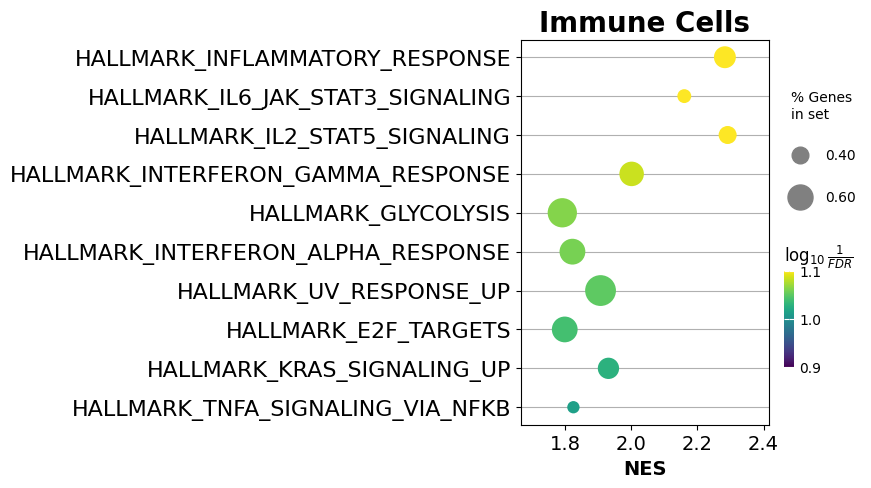

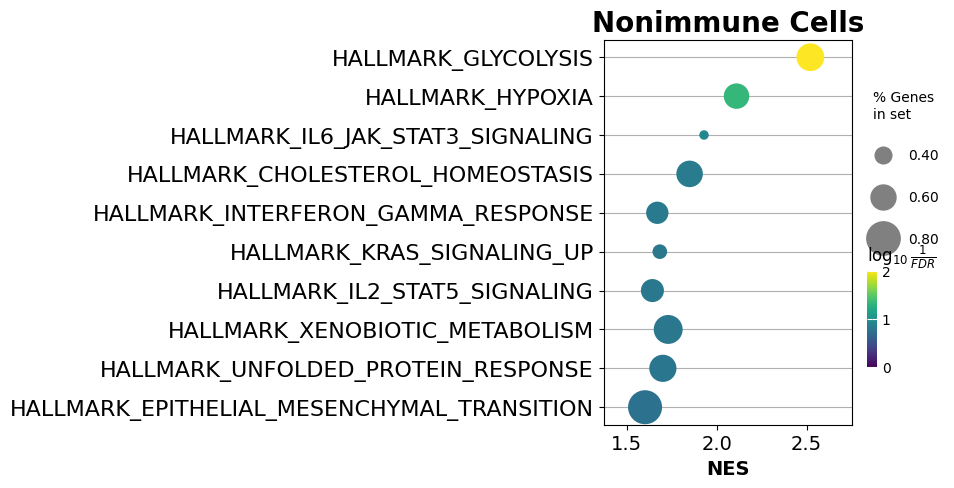

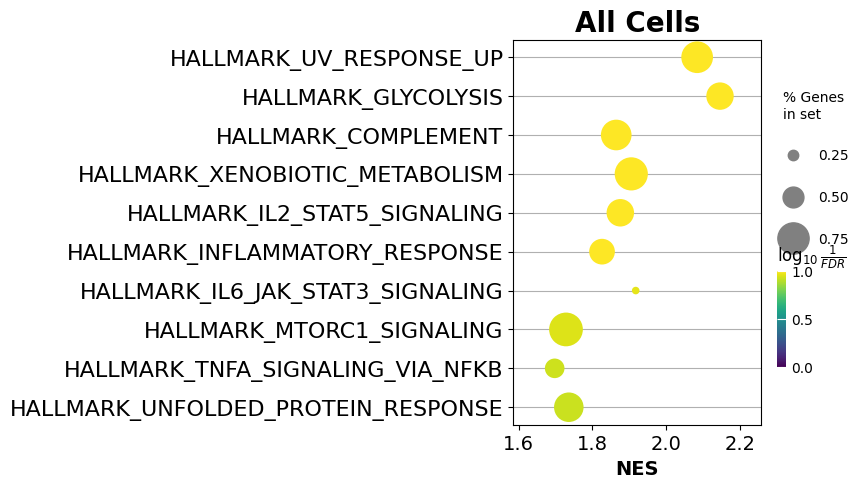

In [57]:
# BuDDI Hallmark

gmt_path = gmt_path_hallmark

cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other"]

title = "Immune Cells"
out_fig, immune_hallmark_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res1, adata_res1_df, title)
out_fig

cell_type_list = ["Endothelial", "Fibroblast"]
title = "Nonimmune Cells"
out_fig, nonimmune_hallmark_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res1, adata_res1_df, title)
out_fig


cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other", "Endothelial", "Fibroblast"]
title = "All Cells"
out_fig, all_hallmark_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res1, adata_res1_df, title)
out_fig

In [50]:
immune_hallmark_BuDDI.res2d

Name                                        Term        ES       NES  \
0   gsea                HALLMARK_IL2_STAT5_SIGNALING  0.244757   2.29135   
1   gsea              HALLMARK_INFLAMMATORY_RESPONSE  0.355265  2.283056   
2   gsea            HALLMARK_IL6_JAK_STAT3_SIGNALING  0.372824  2.160419   
3   gsea          HALLMARK_INTERFERON_GAMMA_RESPONSE  0.364237  2.001349   
4   gsea                  HALLMARK_KRAS_SIGNALING_UP  0.252185  1.931363   
5   gsea                     HALLMARK_UV_RESPONSE_UP  0.244484  1.907465   
6   gsea                         HALLMARK_COMPLEMENT  0.268547  1.837122   
7   gsea            HALLMARK_TNFA_SIGNALING_VIA_NFKB  0.242558  1.825466   
8   gsea          HALLMARK_INTERFERON_ALPHA_RESPONSE  0.369138  1.822589   
9   gsea                        HALLMARK_E2F_TARGETS   0.26236  1.799337   
10  gsea                         HALLMARK_GLYCOLYSIS  0.217177  1.791972   
11  gsea                HALLMARK_ALLOGRAFT_REJECTION   0.35929  1.696041   
12  gsea    HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY  0.417629   1.66919   
13  gsea              HALLMARK_XENOBIOTIC_METABOLISM  0.239838  1.620894   
14  gsea          HALLMARK_UNFOLDED_PROTEIN_RESPONSE  0.269537  1.597973   
15  gsea                        HALLMARK_P53_PATHWAY  0.157918  1.578082   
16  gsea                   HALLMARK_MTORC1_SIGNALING  0.278794  1.556916   
17  gsea                     HALLMARK_G2M_CHECKPOINT  0.182664  1.535185   
18  gsea                     HALLMARK_MYC_TARGETS_V2  0.324536  1.512515   
19  gsea            HALLMARK_PI3K_AKT_MTOR_SIGNALING  0.230053  1.479956   
20  gsea                  HALLMARK_PROTEIN_SECRETION  0.244734  1.387524   
21  gsea          HALLMARK_OXIDATIVE_PHOSPHORYLATION  0.402049  1.377805   
22  gsea                     HALLMARK_MYC_TARGETS_V1  0.371037  1.366901   
23  gsea                            HALLMARK_HYPOXIA  0.151677  1.325595   
24  gsea                       HALLMARK_ANGIOGENESIS  0.254281  1.319028   
25  gsea             HALLMARK_ESTROGEN_RESPONSE_LATE  0.138828  1.303868   
26  gsea         HALLMARK_WNT_BETA_CATENIN_SIGNALING -0.314576 -1.299286   
27  gsea                         HALLMARK_DNA_REPAIR  0.190372  1.271173   
28  gsea               HALLMARK_BILE_ACID_METABOLISM  0.185399  1.232105   
29  gsea                       HALLMARK_ADIPOGENESIS  0.183224  1.224121   
30  gsea                  HALLMARK_ANDROGEN_RESPONSE  0.173708  1.195673   
31  gsea            HALLMARK_CHOLESTEROL_HOMEOSTASIS  0.179516  1.177507   
32  gsea                    HALLMARK_NOTCH_SIGNALING -0.250286 -1.173079   
33  gsea              HALLMARK_FATTY_ACID_METABOLISM  0.240159  1.134187   
34  gsea                    HALLMARK_MITOTIC_SPINDLE -0.192858 -1.038571   
35  gsea                    HALLMARK_HEME_METABOLISM  0.104097  0.997432   
36  gsea                 HALLMARK_TGF_BETA_SIGNALING  -0.16258 -0.985305   
37  gsea                  HALLMARK_KRAS_SIGNALING_DN  -0.18132 -0.958185   
38  gsea            HALLMARK_ESTROGEN_RESPONSE_EARLY -0.112274 -0.953177   
39  gsea                          HALLMARK_APOPTOSIS  0.130796  0.952873   
40  gsea                    HALLMARK_APICAL_JUNCTION -0.140228 -0.947823   
41  gsea                     HALLMARK_UV_RESPONSE_DN  -0.15091 -0.939284   
42  gsea                         HALLMARK_PEROXISOME  0.145127  0.920857   
43  gsea                         HALLMARK_MYOGENESIS -0.149607 -0.846137   
44  gsea                    HALLMARK_SPERMATOGENESIS  0.133401  0.835163   
45  gsea                 HALLMARK_HEDGEHOG_SIGNALING -0.205276 -0.773178   
46  gsea                        HALLMARK_COAGULATION  0.139518  0.731096   
47  gsea  HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION  0.118112  0.609461   
48  gsea                     HALLMARK_APICAL_SURFACE  0.107908  0.563727   

   NOM p-val FDR q-val FWER p-val    Tag %  Gene %  \
0        0.0  0.065005      0.037   61/141  26.29%   
1   0.003914   0.03405      0.039   81/154  27.43%   
2   0.003922  0.042305      0.064    22/6

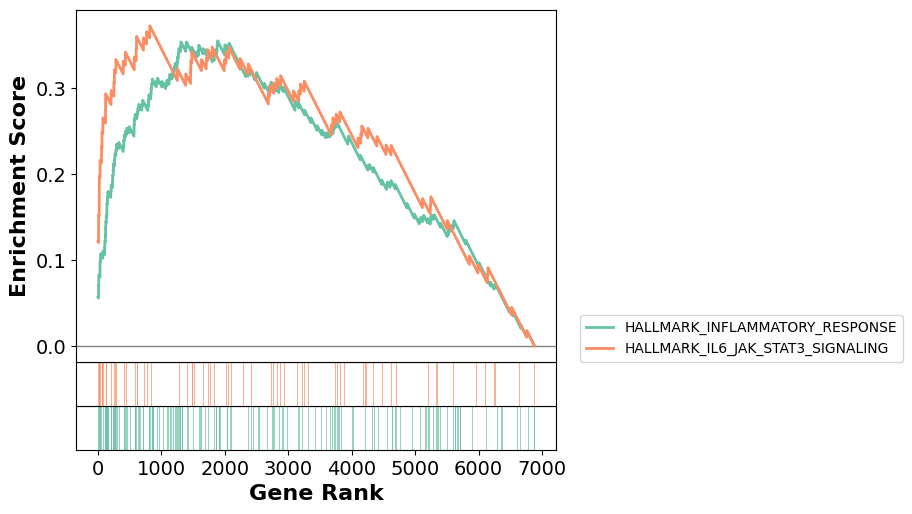

In [54]:

terms = immune_hallmark_BuDDI.res2d.Term
axs = immune_hallmark_BuDDI.plot(terms[[1,2]], show_ranking=False, legend_kws={'loc': (1.05, 0)}, )


In [55]:
nonimmune_hallmark_BuDDI.res2d

Name                                        Term        ES       NES  \
0   gsea                         HALLMARK_GLYCOLYSIS  0.286842  2.521292   
1   gsea                            HALLMARK_HYPOXIA  0.209342  2.110708   
2   gsea            HALLMARK_IL6_JAK_STAT3_SIGNALING   0.35008  1.930001   
3   gsea            HALLMARK_CHOLESTEROL_HOMEOSTASIS  0.254202   1.84988   
4   gsea                       HALLMARK_ANGIOGENESIS  0.323755  1.765584   
5   gsea            HALLMARK_TNFA_SIGNALING_VIA_NFKB  0.276849  1.731024   
6   gsea              HALLMARK_XENOBIOTIC_METABOLISM  0.242317  1.730879   
7   gsea          HALLMARK_UNFOLDED_PROTEIN_RESPONSE  0.302059  1.701277   
8   gsea                  HALLMARK_KRAS_SIGNALING_UP  0.226662  1.684301   
9   gsea          HALLMARK_INTERFERON_GAMMA_RESPONSE  0.286345   1.67038   
10  gsea                HALLMARK_IL2_STAT5_SIGNALING  0.172533  1.643175   
11  gsea  HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION  0.292388  1.602297   
12  gsea          HALLMARK_INTERFERON_ALPHA_RESPONSE   0.29271  1.550052   
13  gsea                        HALLMARK_COAGULATION  0.285755  1.544872   
14  gsea         HALLMARK_WNT_BETA_CATENIN_SIGNALING -0.311443  -1.51955   
15  gsea              HALLMARK_INFLAMMATORY_RESPONSE  0.276445  1.504454   
16  gsea                  HALLMARK_ANDROGEN_RESPONSE  0.201696  1.470608   
17  gsea                         HALLMARK_PEROXISOME  0.245258  1.455462   
18  gsea    HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY   0.33003  1.446268   
19  gsea          HALLMARK_OXIDATIVE_PHOSPHORYLATION  0.389778   1.43057   
20  gsea                     HALLMARK_UV_RESPONSE_UP   0.18637  1.413764   
21  gsea                     HALLMARK_APICAL_SURFACE  0.221776  1.354947   
22  gsea                     HALLMARK_MYC_TARGETS_V1  0.332833  1.348162   
23  gsea                       HALLMARK_ADIPOGENESIS  0.279666  1.335956   
24  gsea             HALLMARK_ESTROGEN_RESPONSE_LATE  0.149947   1.27197   
25  gsea                    HALLMARK_SPERMATOGENESIS  0.182281  1.236657   
26  gsea              HALLMARK_FATTY_ACID_METABOLISM  0.288243  1.214673   
27  gsea                  HALLMARK_PROTEIN_SECRETION   0.23005  1.203564   
28  gsea                 HALLMARK_TGF_BETA_SIGNALING  0.199939  1.202844   
29  gsea                   HALLMARK_MTORC1_SIGNALING  0.178921  1.195461   
30  gsea                          HALLMARK_APOPTOSIS  0.169028   1.13008   
31  gsea                         HALLMARK_COMPLEMENT  0.158614  1.100228   
32  gsea                        HALLMARK_P53_PATHWAY  0.100917  1.014561   
33  gsea                    HALLMARK_MITOTIC_SPINDLE -0.166701 -1.009423   
34  gsea                     HALLMARK_MYC_TARGETS_V2  0.218893  0.991172   
35  gsea            HALLMARK_ESTROGEN_RESPONSE_EARLY  0.115004  0.990972   
36  gsea                  HALLMARK_KRAS_SIGNALING_DN  0.193535  0.961682   
37  gsea                    HALLMARK_HEME_METABOLISM  0.095506  0.870752   
38  gsea                HALLMARK_ALLOGRAFT_REJECTION  0.199096    0.8362   
39  gsea                         HALLMARK_DNA_REPAIR  0.133376   0.81352   
40  gsea               HALLMARK_BILE_ACID_METABOLISM  0.135623  0.806067   
41  gsea            HALLMARK_PI3K_AKT_MTOR_SIGNALING -0.117884 -0.768354   
42  gsea                     HALLMARK_UV_RESPONSE_DN   0.11711  0.726018   
43  gsea                         HALLMARK_MYOGENESIS  0.098854  0.696817   
44  gsea                        HALLMARK_E2F_TARGETS -0.069478 -0.566536   
45  gsea                    HALLMARK_NOTCH_SIGNALING -0.110811 -0.548339   
46  gsea                    HALLMARK_APICAL_JUNCTION  0.064291  0.530556   
47  gsea                 HALLMARK_HEDGEHOG_SIGNALING  0.109687  0.515486   
48  gsea                     HALLMARK_G2M_CHECKPOINT  0.060312   0.49884   

   NOM p-val FDR q-val FWER p-val    Tag %  Gene %  \
0        0.0  0.001733      0.001   74/111  43.56%   
1   0.005425  0.046797      0.046   91/149  47.56%   
2   0.006012  0.119593      0.151    15/6

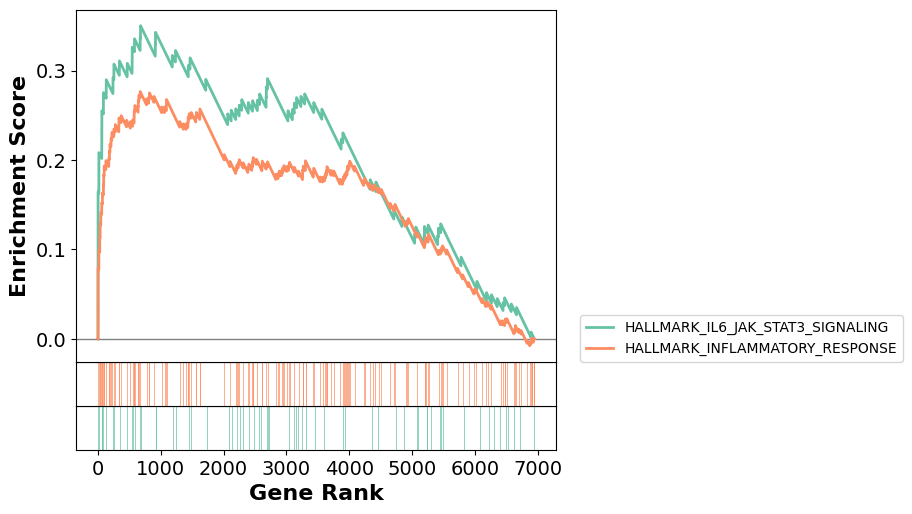

In [56]:

terms = nonimmune_hallmark_BuDDI.res2d.Term
axs = nonimmune_hallmark_BuDDI.plot(terms[[2,15]], show_ranking=False, legend_kws={'loc': (1.05, 0)}, )


<AxesSubplot: title={'center': 'all_hallmark_BuDDI'}, xlabel='NES'>

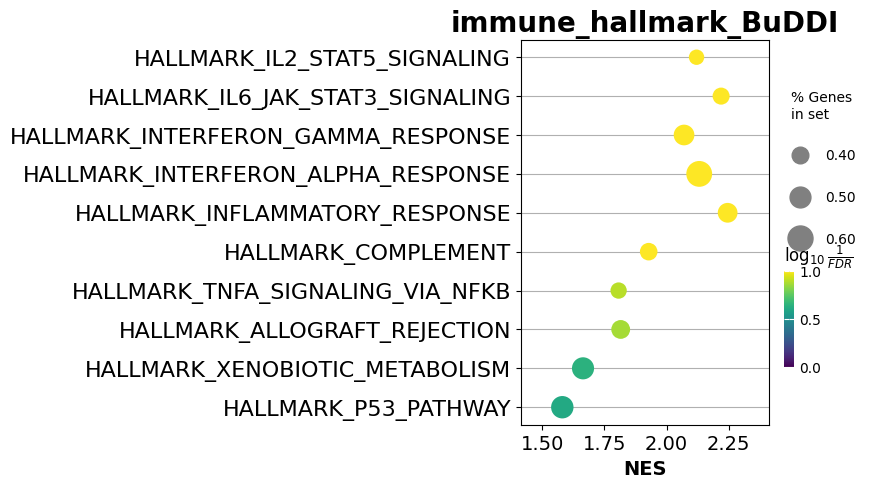

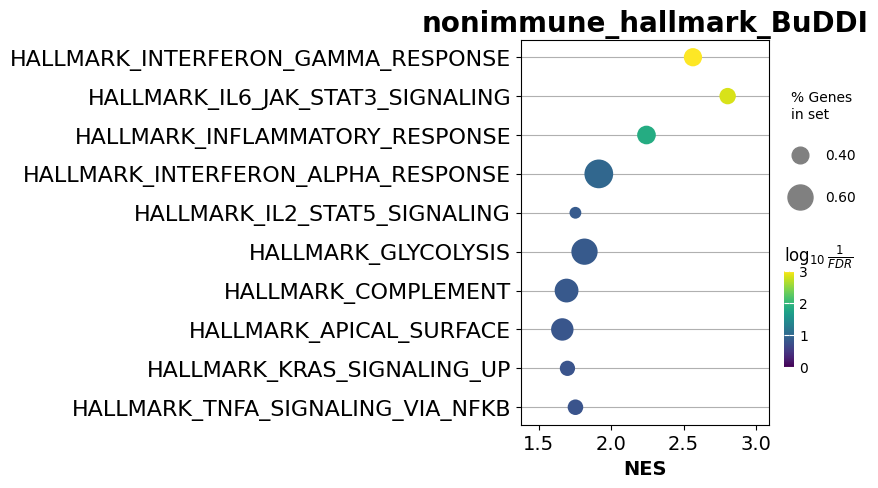

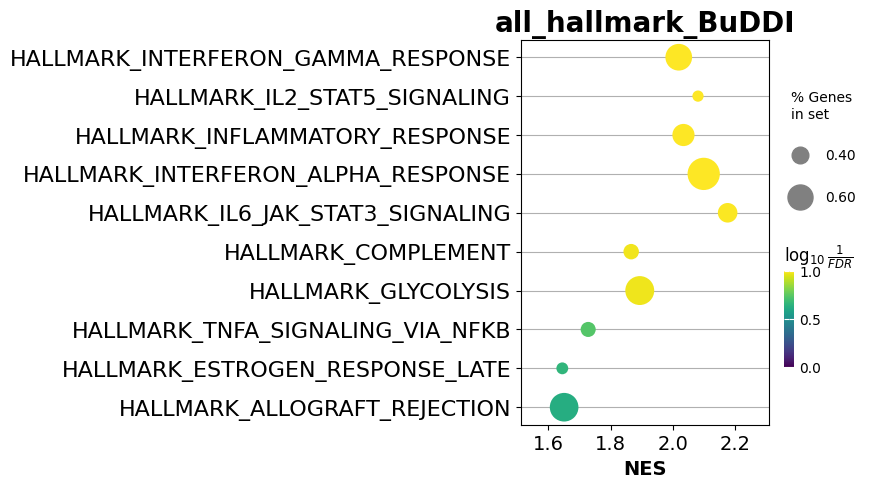

In [24]:
# BuDDI Hallmark

gmt_path = gmt_path_hallmark

cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other"]

title = "immune_hallmark_BuDDI"
out_fig, immune_hallmark_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res2, adata_res2_df, title)
out_fig

cell_type_list = ["Endothelial", "Fibroblast"]
title = "nonimmune_hallmark_BuDDI"
out_fig, nonimmune_hallmark_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res2, adata_res2_df, title)
out_fig


cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other", "Endothelial", "Fibroblast"]
title = "all_hallmark_BuDDI"
out_fig, all_hallmark_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res2, adata_res2_df, title)
out_fig

<AxesSubplot: title={'center': 'all_hallmark_BuDDI'}, xlabel='NES'>

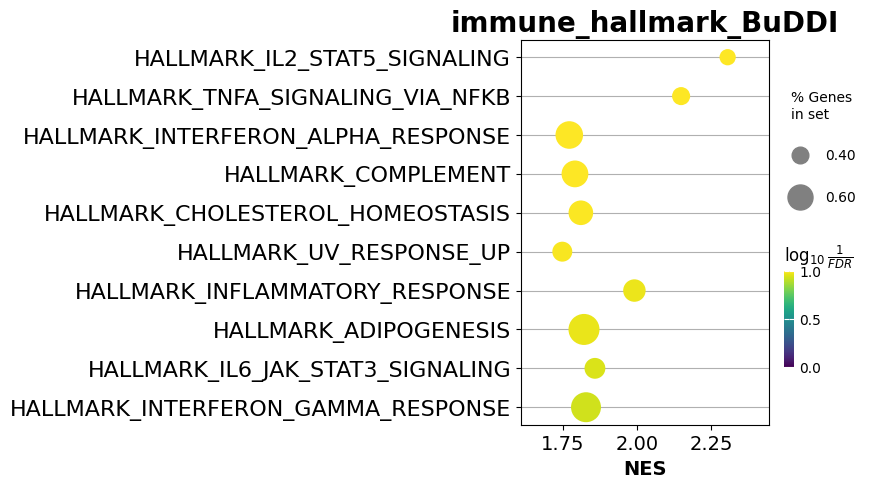

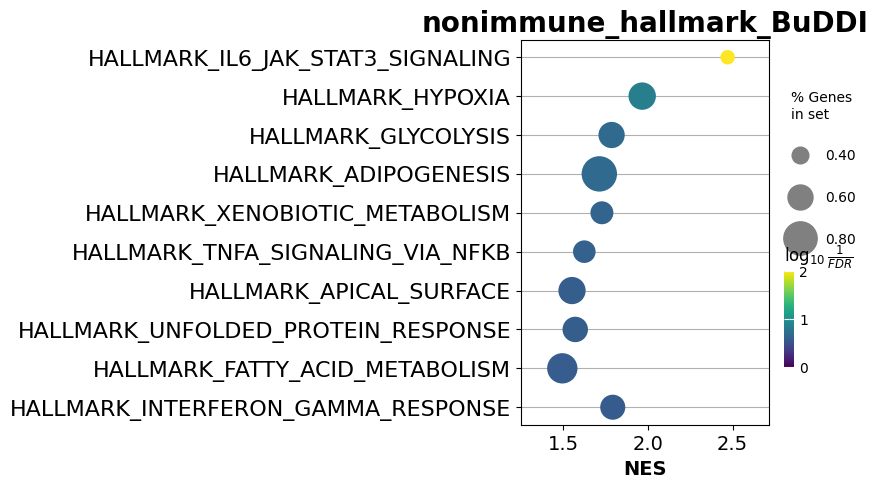

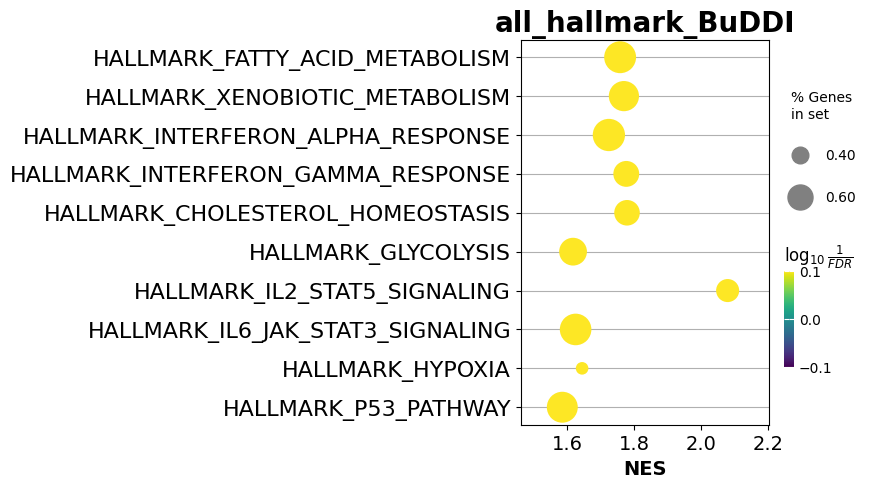

In [25]:
# BuDDI Hallmark

gmt_path = gmt_path_hallmark

cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other"]

title = "immune_hallmark_BuDDI"
out_fig, immune_hallmark_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res3, adata_res3_df, title)
out_fig

cell_type_list = ["Endothelial", "Fibroblast"]
title = "nonimmune_hallmark_BuDDI"
out_fig, nonimmune_hallmark_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res3, adata_res3_df, title)
out_fig


cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other", "Endothelial", "Fibroblast"]
title = "all_hallmark_BuDDI"
out_fig, all_hallmark_BuDDI = plot_gsea(gmt_path, cell_type_list, adata_res3, adata_res3_df, title)
out_fig

<AxesSubplot: title={'center': 'all_hallmark_BP'}, xlabel='NES'>

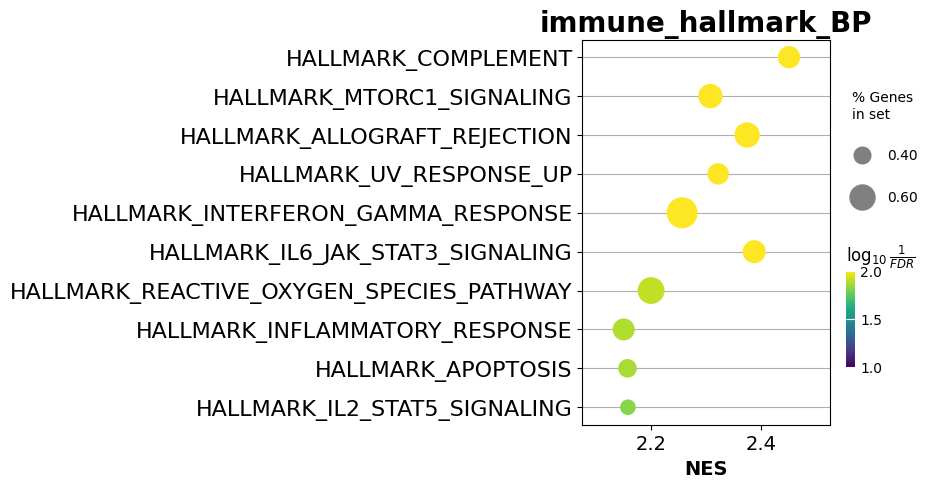

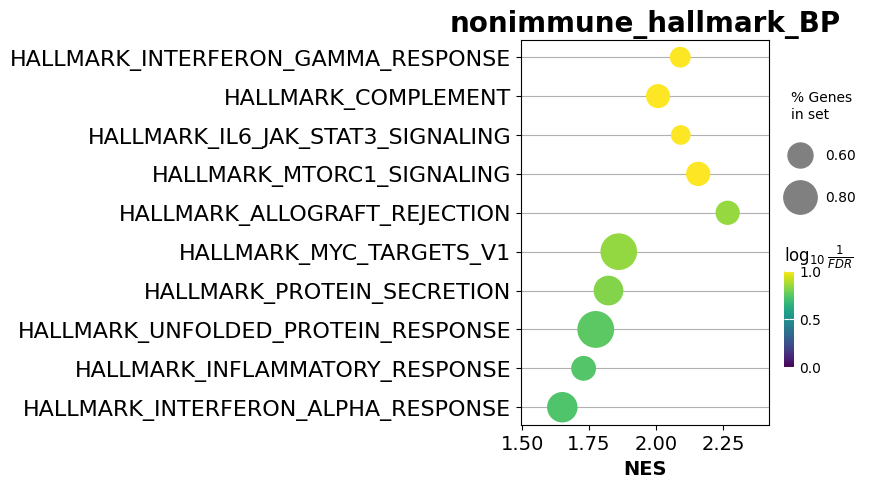

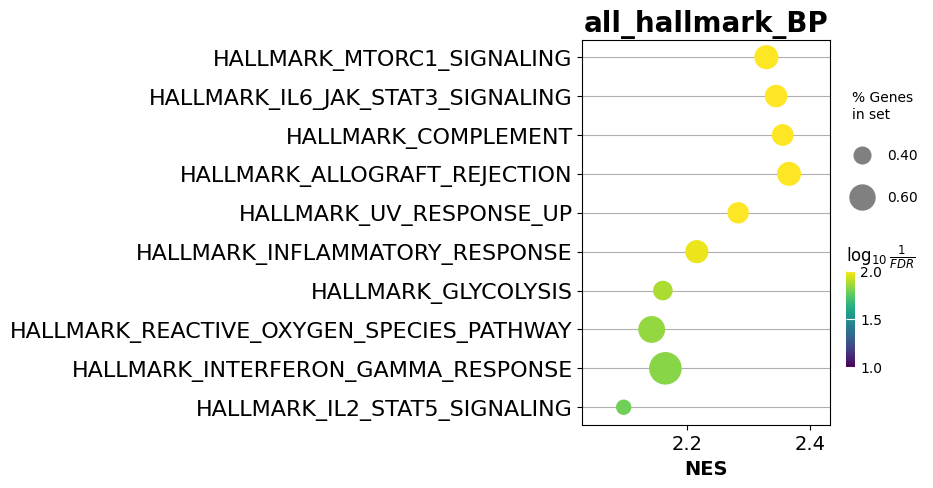

In [26]:
# BP Hallmark

gmt_path = gmt_path_hallmark

cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other"]

title = "immune_hallmark_BP"
out_fig, immune_hallmark_BP = plot_gsea(gmt_path, cell_type_list, bp_adata, bp_adata_df, title)
out_fig

cell_type_list = ["Endothelial", "Fibroblast"]
title = "nonimmune_hallmark_BP"
out_fig, nonimmune_hallmark_BP = plot_gsea(gmt_path, cell_type_list, bp_adata, bp_adata_df, title)
out_fig


cell_type_list = ["NK", "B", "Myeloid", "T_CD4", "T_CD8", "T_other", "Endothelial", "Fibroblast"]
title = "all_hallmark_BP"
out_fig, all_hallmark_BP = plot_gsea(gmt_path, cell_type_list, bp_adata, bp_adata_df, title)
out_fig

In [27]:
all_hallmark_BP.res2d.iloc[0:10]

Name                                      Term        ES       NES  \
0  gsea              HALLMARK_ALLOGRAFT_REJECTION  0.602191  2.365865   
1  gsea                       HALLMARK_COMPLEMENT  0.454166  2.355699   
2  gsea          HALLMARK_IL6_JAK_STAT3_SIGNALING  0.592571  2.344888   
3  gsea                 HALLMARK_MTORC1_SIGNALING   0.38711  2.329126   
4  gsea                   HALLMARK_UV_RESPONSE_UP  0.312231  2.283253   
5  gsea            HALLMARK_INFLAMMATORY_RESPONSE  0.523459  2.216031   
6  gsea        HALLMARK_INTERFERON_GAMMA_RESPONSE  0.573289  2.165025   
7  gsea                       HALLMARK_GLYCOLYSIS  0.329188  2.160933   
8  gsea  HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY  0.433747  2.142748   
9  gsea                        HALLMARK_APOPTOSIS  0.290518   2.10745   

  NOM p-val FDR q-val FWER p-val    Tag %  Gene %  \
0       0.0  0.006186      0.005   91/158  15.19%   
1       0.0  0.004949      0.008   88/168  21.70%   
2       0.0  0.003712      0.008    40/74  17.61%   
3  0.002845  0.003402      0.009  110/190  29.84%   
4   0.00113  0.006186      0.022   72/140  32.00%   
5       0.0  0.010723      0.041   98/176  21.35%   
6  0.006192  0.015024      0.063  147/188  30.44%   
7       0.0  0.013455      0.065   78/166  26.07%   
8  0.001439  0.014572      0.078    29/45  31.22%   
9  0.002328  0.016456       0.09   66/146  29.11%   

                                          Lead_genes  
0  CCL7;CXCL13;IL1B;CCL13;GZMB;IL6;CXCL9;SRGN;IL2...  
1  S100A9;GZMB;CR1;IL6;KCNIP2;CTSL;FCER1G;CR2;GZM...  
2  CCL7;CXCL13;CXCL10;IL1B;CXCL3;IL6;CXCL9;IL2RA;...  
3  XBP1;TM7SF2;TFRC;GLRX;NAMPT;CTSC;SDF2L1;PDK1;S...  
4  IL6;CXCL2;TFRC;C4BPB;SOD2;PPIF;GCH1;ATP6V1F;TS...  
5  CCL7;CXCL10;CXCL8;IL1B;IL6;CXCL6;CXCL9;FPR1;CX...  
6  CCL7;FCGR1A;CXCL10;IDO1;IL6;CXCL9;FPR1;SLAMF7;...  
7  ISG20;GLRX;SPAG4;TXN;SDC1;STC1;HK2;VEGFA;CXCR4...  
8  GLRX;TXN;MGST1;ATOX1;SOD2;NDUFA6;LAMTOR5;PRDX1...  
9  IL1B;IL6;ISG20;CD38;SOD2;IFITM3;CD14;GCH1;CASP...

In [28]:
hallmark_idx = np.where(np.isin(all_hallmark_BP.res2d.Term, ["HALLMARK_IL6_JAK_STAT3_SIGNALING"]))[0]
terms = all_hallmark_BP.res2d.Term[hallmark_idx].tolist()


## Run GSVA

In [23]:

def get_cell_score(gmt_path, adata, adata_df, curr_cell_type):

    curr_adata = adata.copy()
    curr_adata_df = adata_df.copy()

    cell_idx = np.where(np.isin(curr_adata.obs.Y_max, [curr_cell_type]))[0]

    curr_adata_df.index = [m+str(n) for m,n in zip(["name_"]*curr_adata_df.shape[0], curr_adata_df.index )]

    hall_mark = gp.read_gmt(path=gmt_path)
    adata_gsea = curr_adata_df.iloc[cell_idx].T
    adata_gsea["Gene"] = adata_gsea.index


    es = gp.gsva(adata_gsea, gene_sets=hall_mark)

    scores_df = pd.DataFrame(es.res2d.pivot(index='Name', columns='Term', values='ES'))
    scores_df["Name_merge"] = scores_df.index.to_list()

    gsva_adata = curr_adata
    gsva_adata.obs["Name_merge"] = [m+str(n) for m,n in zip(["name_"]*curr_adata_df.shape[0], range(curr_adata_df.shape[0]) )]

    gsva_adata = gsva_adata.obs.merge(scores_df, on="Name_merge")

    return gsva_adata


def get_cell_score_all(gmt_path, adata, adata_df, kcdf="Gaussian"):

    curr_adata = adata.copy()
    curr_adata_df = adata_df.copy()

    sample_size = np.min([1000, curr_adata_df.shape[0]])
    cell_idx = sample(range(curr_adata_df.shape[0]), sample_size)

    curr_adata_df.index = [m+str(n) for m,n in zip(["name_"]*curr_adata_df.shape[0], curr_adata_df.index )]

    hall_mark = gp.read_gmt(path=gmt_path)
    adata_gsea = curr_adata_df.iloc[cell_idx].T
    adata_gsea["Gene"] = adata_gsea.index


    es = gp.gsva(adata_gsea, gene_sets=hall_mark, kcdf=kcdf)

    scores_df = pd.DataFrame(es.res2d.pivot(index='Name', columns='Term', values='ES'))
    scores_df["Name_merge"] = scores_df.index.to_list()

    gsva_adata = curr_adata
    gsva_adata.obs["Name_merge"] = [m+str(n) for m,n in zip(["name_"]*curr_adata_df.shape[0], range(curr_adata_df.shape[0]) )]

    gsva_adata = gsva_adata.obs.merge(scores_df, on="Name_merge")

    return gsva_adata

# test significance of pathway scores
def test_gsva_wilcox(gsva_adata, curr_cell_type, curr_pathway):
    temp_test_df = gsva_adata.iloc[np.where(gsva_adata.Y_max == curr_cell_type)[0]]

    ctrl_idx = np.where(temp_test_df.stim == "CTRL")[0]
    stim_idx = np.where(temp_test_df.stim == "STIM")[0]

    len_test = np.min([len(ctrl_idx), len(stim_idx)])

    print(len_test)

    res = wilcoxon(temp_test_df[curr_pathway].iloc[ctrl_idx][0:len_test], temp_test_df[curr_pathway].iloc[stim_idx][0:len_test])

    return res

### GSVA BuDDI

/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_85974/246659437.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  df2 = pd.DataFrame({col:vals[curr_pathway] for col,vals in grouped})
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_85974/246659437.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


67
74
57
60
55
55
47
56
Fibroblast: WilcoxonResult(statistic=259.0, pvalue=3.8620099989836045e-08)
Myeloid: WilcoxonResult(statistic=226.0, pvalue=3.9176345117123906e-10)
T_other: WilcoxonResult(statistic=769.0, pvalue=0.6477792489833079)
Endothelial: WilcoxonResult(statistic=20.0, pvalue=4.4388946978634824e-11)
T_CD4: WilcoxonResult(statistic=213.0, pvalue=3.0585042467073496e-06)
B: WilcoxonResult(statistic=50.0, pvalue=1.6138767226842022e-09)
NK: WilcoxonResult(statistic=6.0, pvalue=3.5297940704652773e-09)
T_CD8: WilcoxonResult(statistic=533.0, pvalue=0.030646909619855223)


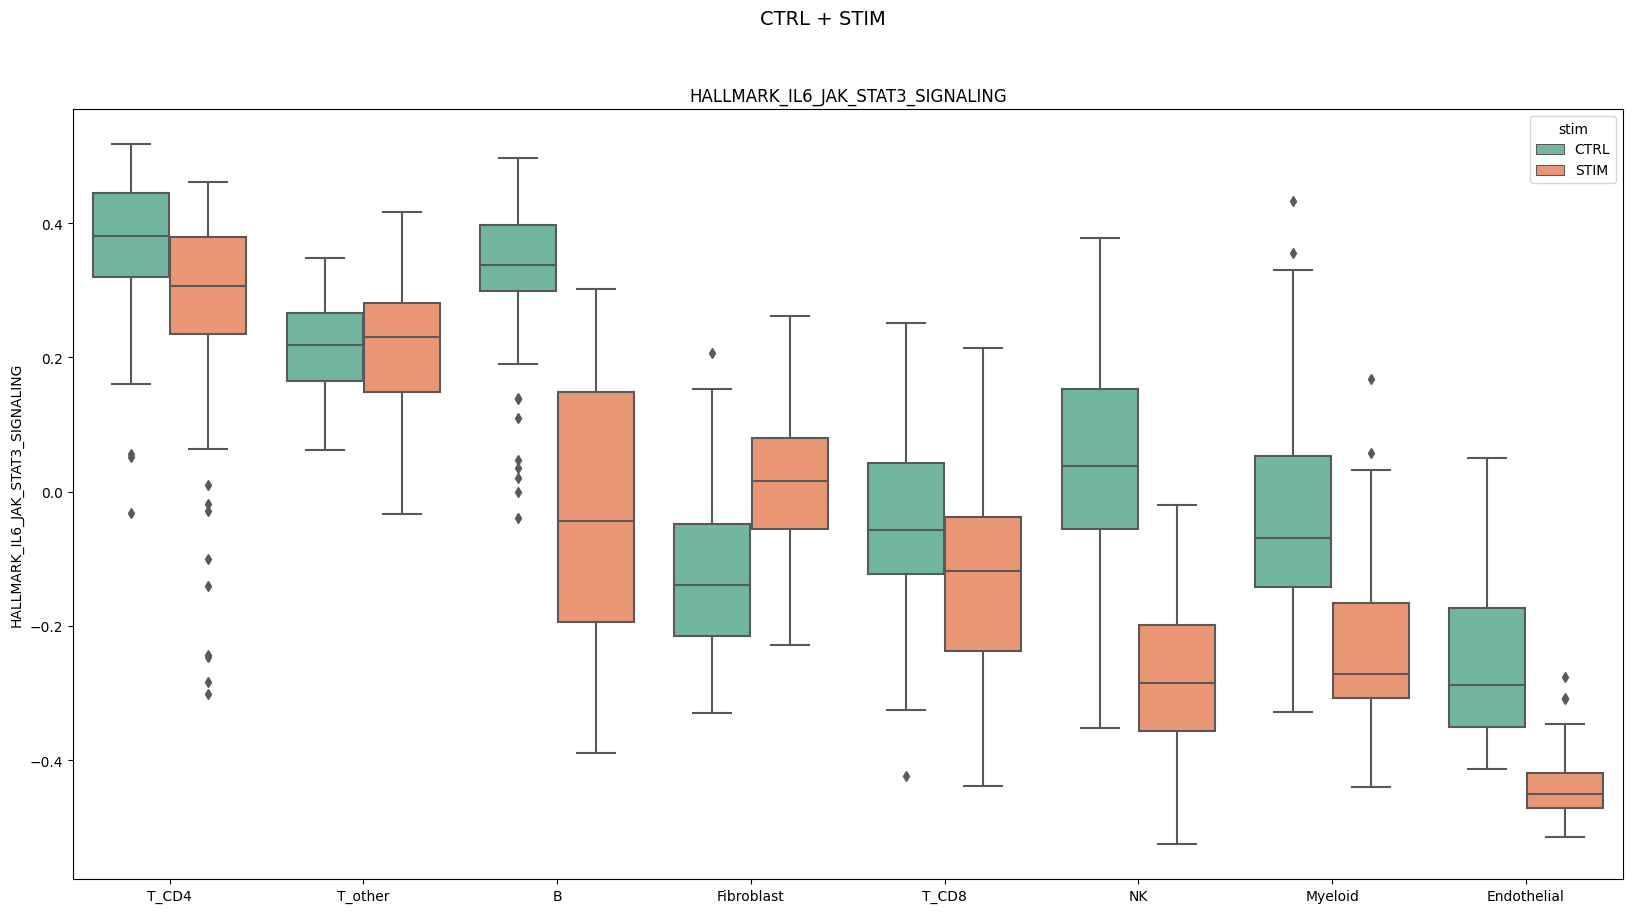

In [25]:
#### Res1 hallmark
gmt_path = gmt_path_hallmark

# run GSVA
curr_pathway = "HALLMARK_IL6_JAK_STAT3_SIGNALING"
gsva_adata_res1 = get_cell_score_all(gmt_path, adata_res1, adata_res1_df, kcdf="Gaussian")

# order the cell types by mean GSVA pathway score
grouped = gsva_adata_res1.groupby(["Y_max"])
df2 = pd.DataFrame({col:vals[curr_pathway] for col,vals in grouped})
meds = df2.mean()
meds.sort_values(ascending=False, inplace=True)
meds.index.to_list()

# plot
fig, axs = plt.subplots(1, 1,  figsize=(20,10))

sns.boxplot(data=gsva_adata_res1, 
        x="Y_max", y=curr_pathway, hue="stim",
        ax= axs, order=meds.index.to_list())

axs.set(ylabel=curr_pathway)


axs.set_title(f"{curr_pathway}")
axs.set(xlabel=None)

fig.suptitle("CTRL + STIM", fontsize=14)
fig.show()

# test significance
curr_pathway = "HALLMARK_IL6_JAK_STAT3_SIGNALING"
Fibroblast_test = test_gsva_wilcox(gsva_adata_res1, "Fibroblast", curr_pathway)
Myeloid_test = test_gsva_wilcox(gsva_adata_res1, "Myeloid", curr_pathway)
T_other_test = test_gsva_wilcox(gsva_adata_res1, "T_other", curr_pathway)
Endothelial_test = test_gsva_wilcox(gsva_adata_res1, "Endothelial", curr_pathway)
T_CD4_test = test_gsva_wilcox(gsva_adata_res1, "T_CD4", curr_pathway)
B_test = test_gsva_wilcox(gsva_adata_res1, "B", curr_pathway)
NK_test = test_gsva_wilcox(gsva_adata_res1, "NK", curr_pathway)
T_CD8_test = test_gsva_wilcox(gsva_adata_res1, "T_CD8", curr_pathway)

print(f"Fibroblast: {Fibroblast_test}")
print(f"Myeloid: {Myeloid_test}")
print(f"T_other: {T_other_test}")
print(f"Endothelial: {Endothelial_test}")
print(f"T_CD4: {T_CD4_test}")
print(f"B: {B_test}")
print(f"NK: {NK_test}")
print(f"T_CD8: {T_CD8_test}")


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_52084/3928291801.py:7: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  df2 = pd.DataFrame({col:vals[curr_pathway] for col,vals in grouped})
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_52084/3928291801.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


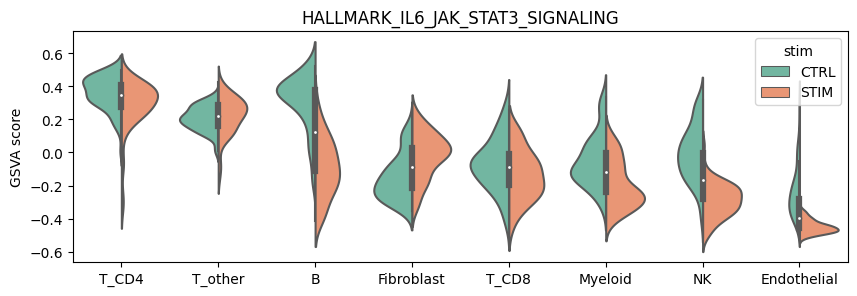

In [92]:
## replot to make nicer figure for the paper
curr_pathway = "HALLMARK_IL6_JAK_STAT3_SIGNALING"


# order the cell types by mean GSVA pathway score
grouped = gsva_adata_res1.groupby(["Y_max"])
df2 = pd.DataFrame({col:vals[curr_pathway] for col,vals in grouped})
meds = df2.median()
meds.sort_values(ascending=False, inplace=True)
meds.index.to_list()

gsva_adata_res1 = gsva_adata_res1.astype({curr_pathway: float})


# plot
fig, axs = plt.subplots(1, 1,  figsize=(10,3))

sns.violinplot(data=gsva_adata_res1, 
        x="Y_max", y=curr_pathway, hue="stim",
        ax= axs, order=meds.index.to_list(),
        split=True)

axs.set(ylabel="GSVA score")


axs.set_title(f"{curr_pathway}")
axs.set(xlabel=None)

fig.show()

/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_85974/3558854975.py:8: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  df2 = pd.DataFrame({col:vals[curr_pathway] for col,vals in grouped})
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_85974/3558854975.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


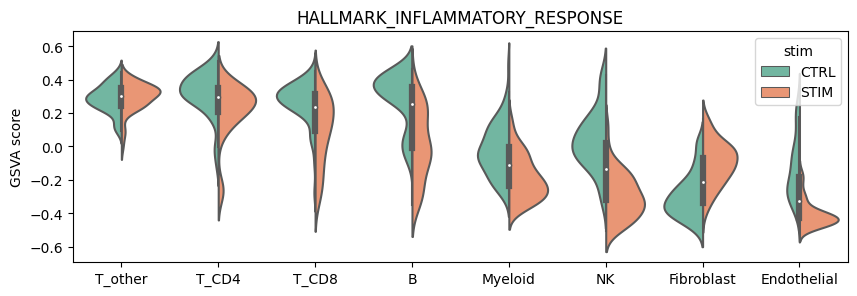

In [26]:
## also include the inflammatory response

curr_pathway = "HALLMARK_INFLAMMATORY_RESPONSE"


# order the cell types by mean GSVA pathway score
grouped = gsva_adata_res1.groupby(["Y_max"])
df2 = pd.DataFrame({col:vals[curr_pathway] for col,vals in grouped})
meds = df2.mean()
meds.sort_values(ascending=False, inplace=True)
meds.index.to_list()

gsva_adata_res1 = gsva_adata_res1.astype({curr_pathway: float})


# plot
fig, axs = plt.subplots(1, 1,  figsize=(10,3))

sns.violinplot(data=gsva_adata_res1, 
        x="Y_max", y=curr_pathway, hue="stim",
        ax= axs, order=meds.index.to_list(),
        split=True)

axs.set(ylabel="GSVA score")

axs.set_title(f"{curr_pathway}")
axs.set(xlabel=None)

fig.show()

/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_52084/2343582276.py:9: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  df2 = pd.DataFrame({col:vals[curr_pathway] for col,vals in grouped})
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_52084/2343582276.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


58
66
61
64
45
67
59
61
Fibroblast: WilcoxonResult(statistic=330.0, pvalue=4.729567663213636e-05)
Myeloid: WilcoxonResult(statistic=41.0, pvalue=1.0453749276813951e-11)
T_other: WilcoxonResult(statistic=238.0, pvalue=3.7384781281439437e-07)
Endothelial: WilcoxonResult(statistic=88.0, pvalue=1.9338465896435903e-10)
T_CD4: WilcoxonResult(statistic=373.0, pvalue=0.1028795125620666)
B: WilcoxonResult(statistic=6.0, pvalue=1.4683150714313257e-12)
NK: WilcoxonResult(statistic=325.0, pvalue=2.3696811363134425e-05)
T_CD8: WilcoxonResult(statistic=301.0, pvalue=3.6690581230844017e-06)


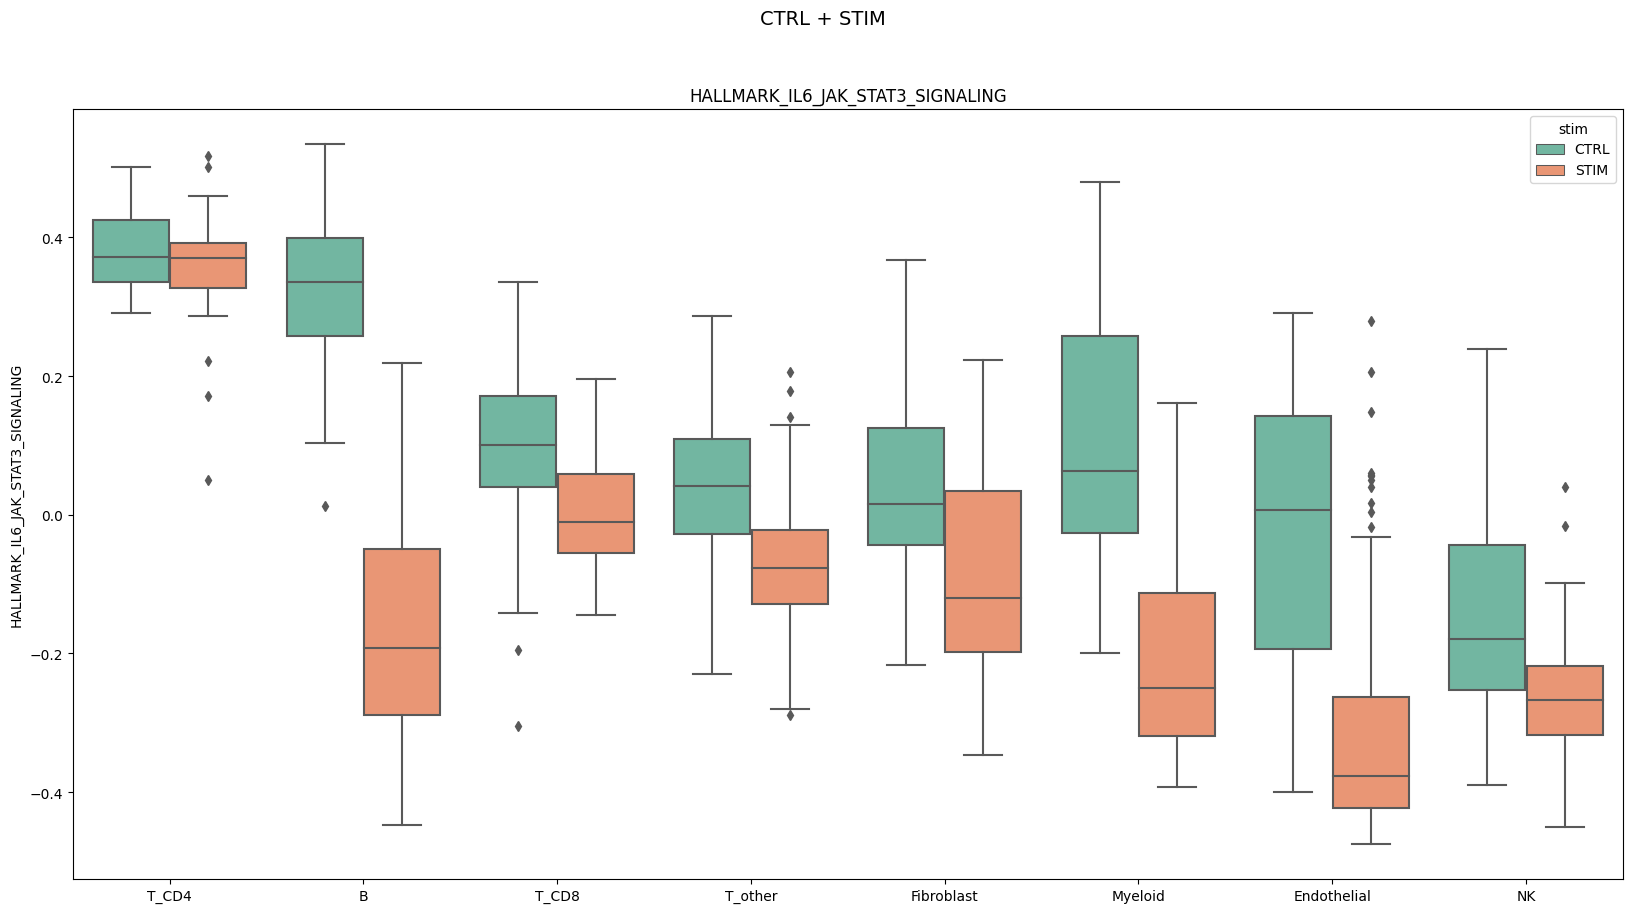

In [31]:
#### Res2

# run GSVA
curr_pathway = "HALLMARK_IL6_JAK_STAT3_SIGNALING"
gsva_adata_res2 = get_cell_score_all(gmt_path, adata_res2, adata_res2_df, kcdf="Gaussian")

# order the cell types by mean GSVA pathway score
grouped = gsva_adata_res2.groupby(["Y_max"])
df2 = pd.DataFrame({col:vals[curr_pathway] for col,vals in grouped})
meds = df2.mean()
meds.sort_values(ascending=False, inplace=True)
meds.index.to_list()

# plot
fig, axs = plt.subplots(1, 1,  figsize=(20,10))

sns.boxplot(data=gsva_adata_res2, 
        x="Y_max", y=curr_pathway, hue="stim",
        ax= axs, order=meds.index.to_list())

axs.set(ylabel=curr_pathway)


axs.set_title(f"{curr_pathway}")
axs.set(xlabel=None)

fig.suptitle("CTRL + STIM", fontsize=14)
fig.show()

# test significance
curr_pathway = "HALLMARK_IL6_JAK_STAT3_SIGNALING"
Fibroblast_test = test_gsva_wilcox(gsva_adata_res2, "Fibroblast", curr_pathway)
Myeloid_test = test_gsva_wilcox(gsva_adata_res2, "Myeloid", curr_pathway)
T_other_test = test_gsva_wilcox(gsva_adata_res2, "T_other", curr_pathway)
Endothelial_test = test_gsva_wilcox(gsva_adata_res2, "Endothelial", curr_pathway)
T_CD4_test = test_gsva_wilcox(gsva_adata_res2, "T_CD4", curr_pathway)
B_test = test_gsva_wilcox(gsva_adata_res2, "B", curr_pathway)
NK_test = test_gsva_wilcox(gsva_adata_res2, "NK", curr_pathway)
T_CD8_test = test_gsva_wilcox(gsva_adata_res2, "T_CD8", curr_pathway)

print(f"Fibroblast: {Fibroblast_test}")
print(f"Myeloid: {Myeloid_test}")
print(f"T_other: {T_other_test}")
print(f"Endothelial: {Endothelial_test}")
print(f"T_CD4: {T_CD4_test}")
print(f"B: {B_test}")
print(f"NK: {NK_test}")
print(f"T_CD8: {T_CD8_test}")


/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_52084/411506120.py:9: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  df2 = pd.DataFrame({col:vals[curr_pathway] for col,vals in grouped})
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_52084/411506120.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


59
56
54
61
55
74
62
55
Fibroblast: WilcoxonResult(statistic=782.0, pvalue=0.4368983210377153)
Myeloid: WilcoxonResult(statistic=45.0, pvalue=8.134295412622499e-10)
T_other: WilcoxonResult(statistic=659.0, pvalue=0.4721697541020634)
Endothelial: WilcoxonResult(statistic=43.0, pvalue=9.024197976469389e-11)
T_CD4: WilcoxonResult(statistic=555.0, pvalue=0.07164176726272269)
B: WilcoxonResult(statistic=220.0, pvalue=3.182892436035783e-10)
NK: WilcoxonResult(statistic=64.0, pvalue=1.578337715875675e-10)
T_CD8: WilcoxonResult(statistic=724.0, pvalue=0.6999312910961195)


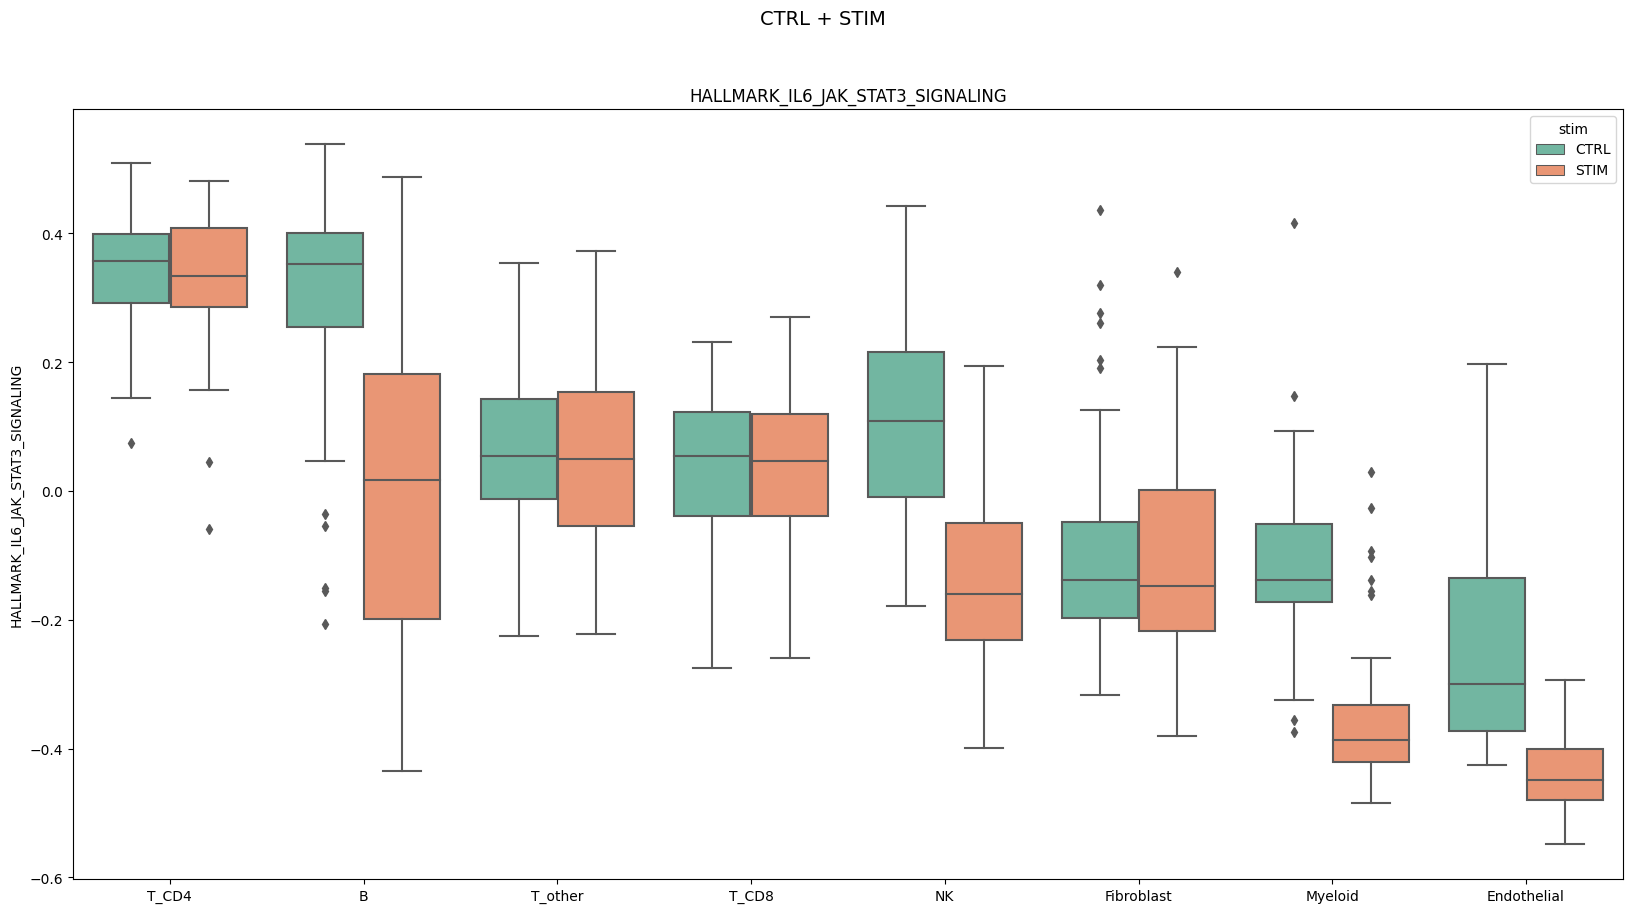

In [32]:
#### Res3

# run GSVA
curr_pathway = "HALLMARK_IL6_JAK_STAT3_SIGNALING"
gsva_adata_res3 = get_cell_score_all(gmt_path, adata_res3, adata_res3_df, kcdf="Gaussian")

# order the cell types by mean GSVA pathway score
grouped = gsva_adata_res3.groupby(["Y_max"])
df2 = pd.DataFrame({col:vals[curr_pathway] for col,vals in grouped})
meds = df2.mean()
meds.sort_values(ascending=False, inplace=True)
meds.index.to_list()

# plot
fig, axs = plt.subplots(1, 1,  figsize=(20,10))

sns.boxplot(data=gsva_adata_res3, 
        x="Y_max", y=curr_pathway, hue="stim",
        ax= axs, order=meds.index.to_list())

axs.set(ylabel=curr_pathway)


axs.set_title(f"{curr_pathway}")
axs.set(xlabel=None)

fig.suptitle("CTRL + STIM", fontsize=14)
fig.show()

# test significance
curr_pathway = "HALLMARK_IL6_JAK_STAT3_SIGNALING"
Fibroblast_test = test_gsva_wilcox(gsva_adata_res3, "Fibroblast", curr_pathway)
Myeloid_test = test_gsva_wilcox(gsva_adata_res3, "Myeloid", curr_pathway)
T_other_test = test_gsva_wilcox(gsva_adata_res3, "T_other", curr_pathway)
Endothelial_test = test_gsva_wilcox(gsva_adata_res3, "Endothelial", curr_pathway)
T_CD4_test = test_gsva_wilcox(gsva_adata_res3, "T_CD4", curr_pathway)
B_test = test_gsva_wilcox(gsva_adata_res3, "B", curr_pathway)
NK_test = test_gsva_wilcox(gsva_adata_res3, "NK", curr_pathway)
T_CD8_test = test_gsva_wilcox(gsva_adata_res3, "T_CD8", curr_pathway)

print(f"Fibroblast: {Fibroblast_test}")
print(f"Myeloid: {Myeloid_test}")
print(f"T_other: {T_other_test}")
print(f"Endothelial: {Endothelial_test}")
print(f"T_CD4: {T_CD4_test}")
print(f"B: {B_test}")
print(f"NK: {NK_test}")
print(f"T_CD8: {T_CD8_test}")


### BayesPrism

/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_52084/2636982990.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


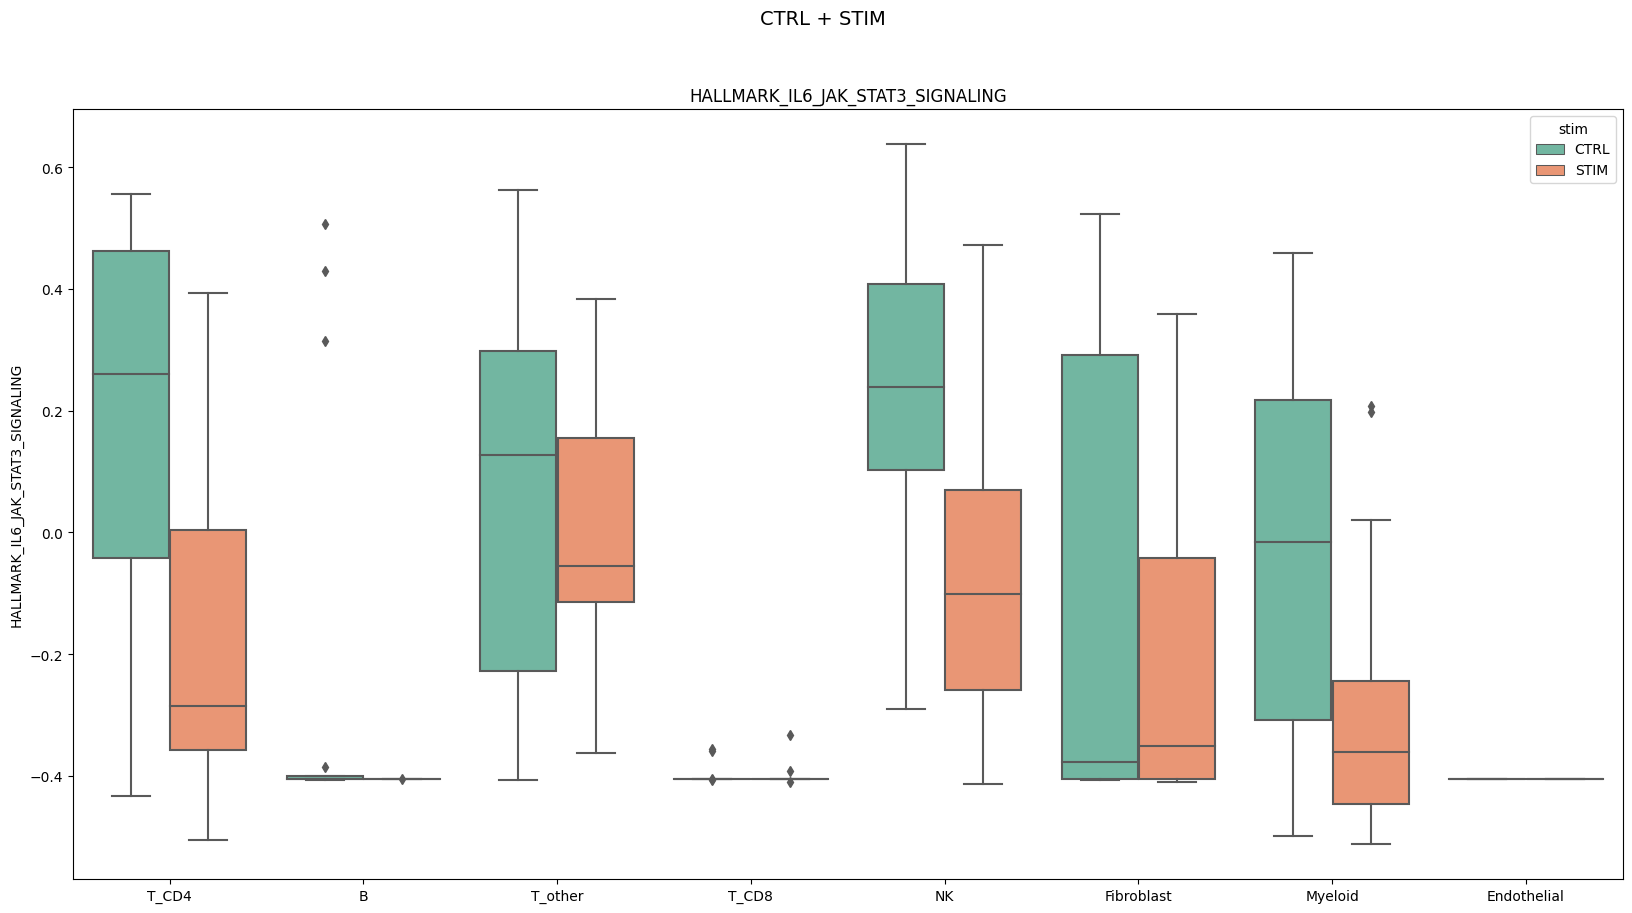

In [33]:
curr_pathway = "HALLMARK_IL6_JAK_STAT3_SIGNALING"
gsva_bp_adata = get_cell_score_all(gmt_path, bp_adata, bp_adata_df, kcdf="Poisson")


fig, axs = plt.subplots(1, 1,  figsize=(20,10))

sns.boxplot(data=gsva_bp_adata, 
        x="Y_max", y=curr_pathway, hue="stim",
        ax= axs, order=meds.index.to_list())

axs.set(ylabel=curr_pathway)


axs.set_title(f"{curr_pathway}")
axs.set(xlabel=None)

fig.suptitle("CTRL + STIM", fontsize=14)
fig.show()


In [34]:
curr_pathway = "HALLMARK_IL6_JAK_STAT3_SIGNALING"
Fibroblast_test = test_gsva_wilcox(gsva_bp_adata, "Fibroblast", curr_pathway)
Myeloid_test = test_gsva_wilcox(gsva_bp_adata, "Myeloid", curr_pathway)
T_other_test = test_gsva_wilcox(gsva_bp_adata, "T_other", curr_pathway)
Endothelial_test = test_gsva_wilcox(gsva_bp_adata, "Endothelial", curr_pathway)
T_CD4_test = test_gsva_wilcox(gsva_bp_adata, "T_CD4", curr_pathway)
B_test = test_gsva_wilcox(gsva_bp_adata, "B", curr_pathway)
NK_test = test_gsva_wilcox(gsva_bp_adata, "NK", curr_pathway)
T_CD8_test = test_gsva_wilcox(gsva_bp_adata, "T_CD8", curr_pathway)

print(f"Fibroblast: {Fibroblast_test}")
print(f"Myeloid: {Myeloid_test}")
print(f"T_other: {T_other_test}")
print(f"Endothelial: {Endothelial_test}")
print(f"T_CD4: {T_CD4_test}")
print(f"B: {B_test}")
print(f"NK: {NK_test}")
print(f"T_CD8: {T_CD8_test}")


/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


16
16
16
16


ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.